In [1]:

# # Vaccines and patient characteristics

In [2]:





# ### Import libraries and data
# 
# The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [3]:


get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

import pandas as pd
import json
from datetime import datetime, timedelta
import subprocess
from IPython.display import display, Markdown, HTML
import os


suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()


# ### Import our custom functions

In [4]:


# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [5]:
from data_processing import load_adult_data
from second_third_doses import abbreviate_time_period


In [6]:


from report_results import find_and_save_latest_date, create_output_dirs, report_results, round7

In [7]:


# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()


# ### Load and Process the raw data 

In [8]:

df = load_adult_data( save_path = savepath )


In [9]:


latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [10]:


print(f"Latest Date: {formatted_latest_date}")


# ### Summarise by group and demographics at latest date

# #### Calculate cumulative sums at each date and select latest date + previous figures for comparison

Latest Date: 25 May 2022


In [11]:


from report_results import cumulative_sums

In [12]:


# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "60-64": 7,
        "55-59": 8,
        "50-54": 9,
        "40-49": 10,
        "30-39": 11,
        "18-29": 12,                
        "16-17": 0 
        # NB if the population denominator is not included for the final group (0), the key must contain phrase "not in other eligible groups" so that data is presented appropriately
        }

groups = population_subgroups.keys()


#  list demographic/clinical factors to include for given group
DEFAULT = ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "housebound", "chronic_cardiac_disease", "current_copd", "dmards", "dementia",
                              "psychosis_schiz_bipolar","LD","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "ckd", "imid"]
#for specific age bands remove features which are included elsehwere or not prevalent
o65 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis")]
o60 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "housebound")]
o50 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "housebound"
                                      )]
o40 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "housebound"
                                       )]
# under50s
u40 = ["sex", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories"]

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {0:    u40, ## patients not assigned to a priority group
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15", "sex", "ageband", "ethnicity_6_groups", "imd_categories",
                                           "LD", "ckd", "imid"],
                 "65-69":    o65,
                 "60-64":    o60,
                 "55-59":    o50,
                 "50-54":    o50,
                 "40-49":    o40,
                 "30-39":    u40,
                 "18-29":    u40,
                 "16-17":    ["sex", "ethnicity_6_groups", "imd_categories"],
                 "LD (aged 16-64)":  ["sex", "ageband_5yr", "ethnicity_6_groups"],
                 "DEFAULT":   DEFAULT # other age groups
                }

In [13]:

df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

In [14]:


# for details on second/third doses, no need for breakdowns of any groups (only "overall" figures will be included)
second_dose_features = {}
for g in groups:
    second_dose_features[g] = []

df_dict_cum_second_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

df_dict_cum_third_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_third_dose_date")


# ### Cumulative vaccination figures - overall

In [15]:


from report_results import make_vaccine_graphs

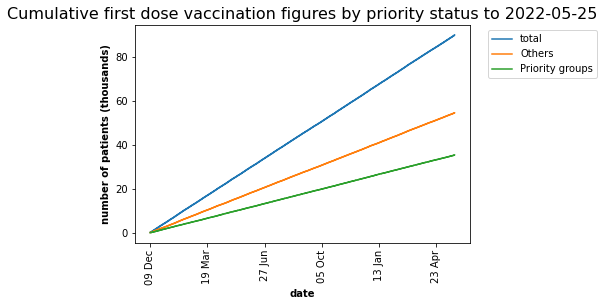

In [16]:


make_vaccine_graphs(df, latest_date=latest_date, grouping="priority_status", savepath_figure_csvs=savepath_figure_csvs, savepath=savepath, suffix=suffix)

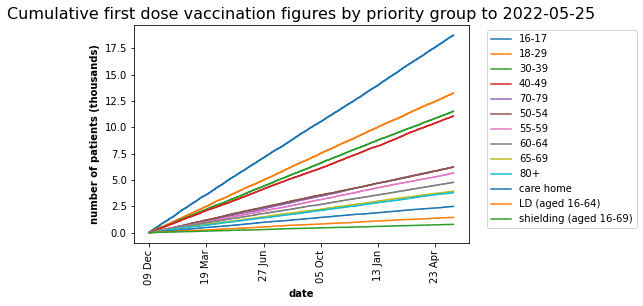

In [17]:


make_vaccine_graphs(df, latest_date=latest_date, include_total=False, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)


# ### Reports 

In [18]:


from report_results import summarise_data_by_group

In [19]:


summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

In [20]:


summarised_data_dict_2nd_dose = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

summarised_data_dict_3rd_dose = summarise_data_by_group(df_dict_cum_third_dose, latest_date=latest_date, groups=groups)


# ### Proportion of each eligible population vaccinated to date

In [21]:


from report_results import create_summary_stats, create_detailed_summary_uptake

In [22]:


summ_stat_results, additional_stats = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, 
                                         savepath=savepath, suffix=suffix)

In [23]:


summ_stat_results_2nd_dose, _ = create_summary_stats(df, summarised_data_dict_2nd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="second_dose", suffix=suffix)

summ_stat_results_3rd_dose, _ = create_summary_stats(df, summarised_data_dict_3rd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="third_dose", suffix=suffix)

In [24]:


# display the results of the summary stats on first and second doses
display(pd.DataFrame(summ_stat_results).join(pd.DataFrame(summ_stat_results_2nd_dose)).join(pd.DataFrame(summ_stat_results_3rd_dose)))   
display(Markdown(f"*\n figures rounded to nearest 7"))

first dose as at 25 May 2022  \
Total vaccinated in TPP                       89,999   
80+                           89.8% (3,808 of 4,242)   
70-79                         89.3% (6,244 of 6,993)   
care home                     90.1% (2,492 of 2,765)   
shielding (aged 16-69)            91.8% (784 of 854)   
65-69                         90.8% (3,934 of 4,333)   
LD (aged 16-64)               88.5% (1,449 of 1,638)   
60-64                         89.6% (4,781 of 5,334)   
55-59                         90.2% (5,670 of 6,286)   
50-54                         90.0% (6,230 of 6,923)   
40-49                       89.9% (11,067 of 12,313)   
30-39                       90.3% (11,529 of 12,761)   
18-29                       89.9% (13,251 of 14,742)   
16-17                       90.1% (18,753 of 20,804)   

                        second dose as at 25 May 2022  \
Total vaccinated in TPP                        80,003   
80+                            80.5% (3,416 of 4,242)   
70-79                          80.2% (5,607 of 6,993)   
care home                      80.8% (2,233 of 2,765)   
shielding (aged 16-69)             78.7% (672 of 854)   
65-69                          80.3% (3,479 of 4,333)   
LD (aged 16-64)                79.9% (1,309 of 1,638)   
60-64                          79.7% (4,249 of 5,334)   
55-59                          80.0% (5,026 of 6,286)   
50-54                          79.7% (5,516 of 6,923)   
40-49                         80.2% (9,877 of 12,313)   
30-39                        80.3% (10,241 of 12,761)   
18-29                        79.6% (11,732 of 14,742)   
16-17                        80.0% (16,639 of 20,804)   

                        third dose as at 25 May 2022  
Total vaccinated in TPP                       10,003  
80+                             10.1% (427 of 4,242)  
70-79                           10.0% (700 of 6,993)  
care home                       10.4% (287 of 2,765)  
shielding (aged 16-69)              9.8% (84 of 854)  
65-69                            9.7% (420 of 4,333)  
LD (aged 16-64)                 10.3% (168 of 1,638)  
60-64                           10.6% (567 of 5,334)  
55-59                            9.7% (609 of 6,286)  
50-54                            9.8% (679 of 6,923)  
40-49                         9.9% (1,225 of 12,313)  
30-39                         9.9% (1,267 of 12,761)  
18-29                        10.1% (1,491 of 14,742)  
16-17                         9.9% (2,065 of 20,804)

*
 figures rounded to nearest 7

In [25]:


# other information on vaccines

for x in additional_stats.keys():
    display(Markdown(f"{x}: {additional_stats[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))


# # Detailed summary of coverage among population groups as at latest date

Oxford-AZ vaccines (% of all first doses): **0.1%** (70)

Pfizer vaccines (% of all first doses): **0.1%** (105)

Moderna vaccines (% of all first doses): **0.1%** (49)

Second doses (% of all vaccinated): **88.9%** (80,003)

Second doses (% of Ox-AZ first doses): **6520.0%** (4,564)

Second doses (% of Pfizer first doses): **2386.7%** (2,506)

Second doses (% of Moderna first doses): **11828.6%** (5,796)

Mixed doses Ox-AZ + Pfizer (% of fully vaccinated): **0.0%** (0)

Mixed doses Ox-AZ + Moderna (% of fully vaccinated): **0.0%** (0)

Mixed doses Moderna + Pfizer (% of fully vaccinated): **0.0%** (0)

*
 figures rounded to nearest 7

In [26]:


create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)


# # Demographics time trend charts

## 

## COVID vaccination rollout (first dose) among **80+** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3808   
sex                       F                                          1946   
                          M                                          1862   
ageband_5yr               0                                            49   
                          0-15                                        252   
                          16-17                                       245   
                          18-29                                       231   
                          30-34                                       259   
                          35-39                                       266   
                          40-44                                       259   
                          45-49                                       280   
                          50-54                                       252   
                          55-59                                       245   
                          60-64                                       231   
                          65-69                                       238   
                          70-74                                       252   
                          75-79                                       245   
                          80-84                                       245   
                          85-89                                       224   
                          90+                                          42   
ethnicity_6_groups        Black                                       616   
                          Mixed                                       658   
                          Other                                       651   
                          South Asian                                 651   
                          Unknown                                     588   
                          White                                       651   
ethnicity_16_groups        African                                    189   
                           Bangladeshi or British Bangladeshi         189   
                           Caribbean                                  203   
                           Chinese                                    203   
                           Other                                      196   
                           Other Asian                                203   
                          British or Mixed British                    203   
                          Indian or British Indian                    217   
                          Irish                                       210   
                          Other Black                                 224   
                          Other White                                 189   
                          Other mixed                                 203   
                          Pakistani or British Pakistani              189   
                          Unknown                                     581   
                          White + Asian                               196   
                          White + Black African                       189   
                          White + Black Caribbean                     210   
imd_categories            1 Most deprived                             707   
                          2                                           714   
                          3                                           742   
                          4                                           763   
                          5 Least deprived                            665   
                          Unknown                                     210   
bmi                       30+                                        1141   
                          under 30                         

## 

## COVID vaccination rollout (first dose) among **70-79** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    6244   
sex                       F                                          3157   
                          M                                          3087   
ageband_5yr               0                                            77   
                          0-15                                        399   
                          16-17                                       434   
                          18-29                                       385   
                          30-34                                       399   
                          35-39                                       420   
                          40-44                                       413   
                          45-49                                       434   
                          50-54                                       413   
                          55-59                                       406   
                          60-64                                       420   
                          65-69                                       399   
                          70-74                                       399   
                          75-79                                       371   
                          80-84                                       399   
                          85-89                                       399   
                          90+                                          70   
ethnicity_6_groups        Black                                      1064   
                          Mixed                                      1099   
                          Other                                      1022   
                          South Asian                                1106   
                          Unknown                                     903   
                          White                                      1043   
ethnicity_16_groups        African                                    322   
                           Bangladeshi or British Bangladeshi         350   
                           Caribbean                                  315   
                           Chinese                                    329   
                           Other                                      329   
                           Other Asian                                343   
                          British or Mixed British                    336   
                          Indian or British Indian                    336   
                          Irish                                       329   
                          Other Black                                 350   
                          Other White                                 336   
                          Other mixed                                 336   
                          Pakistani or British Pakistani              315   
                          Unknown                                     938   
                          White + Asian                               308   
                          White + Black African                       329   
                          White + Black Caribbean                     343   
imd_categories            1 Most deprived                            1148   
                          2                                          1190   
                          3                                          1190   
                          4                                          1197   
                          5 Least deprived                           1211   
                          Unknown                                     315   
bmi                       30+                                        1918   
                          under 30                         

## 

## COVID vaccination rollout (first dose) among **care home** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            2492     90.1   2765   
sex                F                  1267     91.4   1386   
                   M                  1225     88.8   1379   
ageband_5yr        0                    35    100.0     35   
                   0-15                168     92.3    182   
                   16-17               140     90.9    154   
                   18-29               182     92.9    196   
                   30-34               154     88.0    175   
                   35-39               154     88.0    175   
                   40-44               154     88.0    175   
                   45-49               168     92.3    182   
                   50-54               189     87.1    217   
                   55-59               168     88.9    189   
                   60-64               175     92.6    189   
                   65-69               154     91.7    168   
                   70-74               154     91.7    168   
                   75-79               175     92.6    189   
                   80-84               154     88.0    175   
                   85-89               154     91.7    168   
                   90+                  28    100.0     28   
ethnicity_6_groups Black               427     91.0    469   
                   Mixed               420     90.9    462   
                   Other               413     89.4    462   
                   South Asian         448     88.9    504   
                   Unknown             343     87.5    392   
                   White               441     91.3    483   
dementia           no                 2464     90.0   2737   
                   yes                  28    100.0     28   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 89.1   
sex                F                                       90.4   
                   M                                       87.8   
ageband_5yr        0                                       80.0   
                   0-15                                    92.3   
                   16-17                                   90.9   
                   18-29                                   92.9   
                   30-34                                   88.0   
                   35-39                                   84.0   
                   40-44                                   88.0   
                   45-49                                   92.3   
                   50-54                                   87.1   
                   55-59                                   85.2   
                   60-64                                   88.9   
                   65-69                                   91.7   
                   70-74                                   91.7   
                   75-79                                   88.9   
                   80-84                                   88.0   
                   85-89                                   87.5   
                   90+                                    100.0   
ethnicity_6_groups Black                                   89.6   
                   Mixed                                   89.4   
                   Other                                   87.9   
                   South Asian                             87.5   
                   Unknown                                 87.5   
                   White                                   91.3   
dementia           no                                      89.0   
                   yes                                    100.0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

## 

## COVID vaccination rollout (first dose) among **shielding (aged 16-69)** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  784     91.8    854   
newly_shielded_since_feb_15 no                       784     92.6    847   
                            yes                        0      0.0      0   
sex                         F                        427     92.4    462   
                            M                        364     92.9    392   
ageband                     16-29                     98     87.5    112   
                            30-39                     98     93.3    105   
                            40-49                    119    100.0    119   
                            50-59                     98     87.5    112   
                            60-69                    105     93.8    112   
                            70-79                    168     88.9    189   
                            80+                       98     93.3    105   
ethnicity_6_groups          Black                    133     90.5    147   
                            Mixed                    140     95.2    147   
                            Other                    133     95.0    140   
                            South Asian              126     85.7    147   
                            Unknown                  119     94.4    126   
                            White                    133     95.0    140   
imd_categories              1 Most deprived          154     91.7    168   
                            2                        147     95.5    154   
                            3                        147     91.3    161   
                            4                        154     95.7    161   
                            5 Least deprived         147     91.3    161   
                            Unknown                   42     85.7     49   
LD                          no                       770     92.4    833   
                            yes                       14    100.0     14   
ckd                         no                       637     92.9    686   
                            yes                      147     91.3    161   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      91.0   
newly_shielded_since_feb_15 no                                           90.9   
                            yes                                           NaN   
sex                         F                                            90.9   
                            M                                            91.1   
ageband                     16-29                                        87.5   
                            30-39                                        93.3   
                            40-49                                        94.1   
                            50-59                                        87.5   
                            60-69                                        87.5   
                            70-79                                        88.9   
                            80+                                          93.3   
ethnicity_6_groups          Black                                        90.5   
                            Mixed                                        95.2   
                            Other                                        90.0   
                            South Asian                                  85.7   
                            Unknown                                      94.4   
                            White                                        95.0   
imd_categories              1 Most deprived                              91.7   
                            2                                   

## 

## COVID vaccination rollout (first dose) among **65-69** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3934   
sex                       F                                          2023   
                          M                                          1918   
ethnicity_6_groups        Black                                       651   
                          Mixed                                       616   
                          Other                                       679   
                          South Asian                                 707   
                          Unknown                                     581   
                          White                                       693   
ethnicity_16_groups        African                                    210   
                           Bangladeshi or British Bangladeshi         217   
                           Caribbean                                  182   
                           Chinese                                    196   
                           Other                                      210   
                           Other Asian                                203   
                          British or Mixed British                    189   
                          Indian or British Indian                    224   
                          Irish                                       210   
                          Other Black                                 231   
                          Other White                                 203   
                          Other mixed                                 217   
                          Pakistani or British Pakistani              217   
                          Unknown                                     574   
                          White + Asian                               217   
                          White + Black African                       217   
                          White + Black Caribbean                     224   
imd_categories            1 Most deprived                             777   
                          2                                           714   
                          3                                           735   
                          4                                           721   
                          5 Least deprived                            777   
                          Unknown                                     210   
bmi                       30+                                        1190   
                          under 30                                   2744   
housebound                no                                         3892   
                          yes                                          42   
chronic_cardiac_disease   no                                         3899   
                          yes                                          35   
current_copd              no                                         3899   
                          yes                                          35   
dmards                    no                                         3906   
                          yes                                          28   
dementia                  no                                         3899   
                          yes                                          35   
psychosis_schiz_bipolar   no                                         3899   
                          yes                                          35   
LD                        no                                         3864   
                          yes                                          70   
ssri                      no                                         3899   
                          yes                                          42   
chemo_or_radio            no                               

## 

## COVID vaccination rollout (first dose) among **LD (aged 16-64)** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            1449     88.5   1638   
sex                F                   749     89.9    833   
                   M                   707     87.8    805   
ageband_5yr        0                    21    100.0     21   
                   0-15                 84     80.0    105   
                   16-17                91     81.2    112   
                   18-29                84     85.7     98   
                   30-34                98     93.3    105   
                   35-39                84     85.7     98   
                   40-44               105    100.0    105   
                   45-49                91     86.7    105   
                   50-54                91     86.7    105   
                   55-59                98     87.5    112   
                   60-64                91     86.7    105   
                   65-69               105     93.8    112   
                   70-74                91     86.7    105   
                   75-79                91     86.7    105   
                   80-84                98     93.3    105   
                   85-89               105     93.8    112   
                   90+                  21    100.0     21   
ethnicity_6_groups Black               259     90.2    287   
                   Mixed               231     86.8    266   
                   Other               245     89.7    273   
                   South Asian         238     89.5    266   
                   Unknown             217     86.1    252   
                   White               259     88.1    294   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 87.6   
sex                F                                       88.2   
                   M                                       86.1   
ageband_5yr        0                                      100.0   
                   0-15                                    80.0   
                   16-17                                   81.2   
                   18-29                                   85.7   
                   30-34                                   93.3   
                   35-39                                   85.7   
                   40-44                                   93.3   
                   45-49                                   86.7   
                   50-54                                   86.7   
                   55-59                                   87.5   
                   60-64                                   86.7   
                   65-69                                   93.8   
                   70-74                                   86.7   
                   75-79                                   86.7   
                   80-84                                   93.3   
                   85-89                                   87.5   
                   90+                                    100.0   
ethnicity_6_groups Black                                   87.8   
                   Mixed                                   86.8   
                   Other                                   89.7   
                   South Asian                             89.5   
                   Unknown                                 86.1   
                   White                                   85.7   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.9   
sex                F                                     1.7   
                   M                                     1.7   
ageband_5yr        0                                     0.0   
                   0-15           

## 

## COVID vaccination rollout (first dose) among **60-64** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    4781   
sex                       F                                          2387   
                          M                                          2394   
ethnicity_6_groups        Black                                       812   
                          Mixed                                       805   
                          Other                                       784   
                          South Asian                                 840   
                          Unknown                                     735   
                          White                                       798   
ethnicity_16_groups        African                                    280   
                           Bangladeshi or British Bangladeshi         224   
                           Caribbean                                  252   
                           Chinese                                    259   
                           Other                                      252   
                           Other Asian                                273   
                          British or Mixed British                    266   
                          Indian or British Indian                    259   
                          Irish                                       238   
                          Other Black                                 266   
                          Other White                                 259   
                          Other mixed                                 259   
                          Pakistani or British Pakistani              245   
                          Unknown                                     700   
                          White + Asian                               245   
                          White + Black African                       259   
                          White + Black Caribbean                     266   
imd_categories            1 Most deprived                             931   
                          2                                           910   
                          3                                           952   
                          4                                           868   
                          5 Least deprived                            889   
                          Unknown                                     224   
bmi                       30+                                        1435   
                          under 30                                   3346   
chronic_cardiac_disease   no                                         4732   
                          yes                                          49   
current_copd              no                                         4746   
                          yes                                          42   
dmards                    no                                         4739   
                          yes                                          42   
dementia                  no                                         4746   
                          yes                                          42   
psychosis_schiz_bipolar   no                                         4732   
                          yes                                          49   
ssri                      no                                         4732   
                          yes                                          49   
chemo_or_radio            no                                         4732   
                          yes                                          56   
lung_cancer               no                                         4739   
                          yes                                          49   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose) among **55-59** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    5670   
sex                     F                                          2912   
                        M                                          2758   
ethnicity_6_groups      Black                                       910   
                        Mixed                                       938   
                        Other                                       966   
                        South Asian                                 952   
                        Unknown                                     896   
                        White                                      1008   
ethnicity_16_groups      African                                    336   
                         Bangladeshi or British Bangladeshi         315   
                         Caribbean                                  287   
                         Chinese                                    280   
                         Other                                      294   
                         Other Asian                                280   
                        British or Mixed British                    259   
                        Indian or British Indian                    322   
                        Irish                                       329   
                        Other Black                                 322   
                        Other White                                 329   
                        Other mixed                                 308   
                        Pakistani or British Pakistani              294   
                        Unknown                                     826   
                        White + Asian                               322   
                        White + Black African                       287   
                        White + Black Caribbean                     287   
imd_categories          1 Most deprived                            1092   
                        2                                          1120   
                        3                                          1092   
                        4                                          1085   
                        5 Least deprived                           1022   
                        Unknown                                     266   
bmi                     30+                                        1673   
                        under 30                                   3997   
chronic_cardiac_disease no                                         5621   
                        yes                                          56   
current_copd            no                                         5614   
                        yes                                          56   
dmards                  no                                         5607   
                        yes                                          70   
psychosis_schiz_bipolar no                                         5621   
                        yes                                          49   
ssri                    no                                         5628   
                        yes                                          49   
ckd                     no                                         4578   
                        yes                                        1099   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 90.2   6286   
sex                     F                                       90.4   3220   
                        M                                       90.0   3066   
ethnicity_6_groups      Black                                   8

## 

## COVID vaccination rollout (first dose) among **50-54** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    6230   
sex                     F                                          3143   
                        M                                          3094   
ethnicity_6_groups      Black                                      1064   
                        Mixed                                      1092   
                        Other                                      1043   
                        South Asian                                1071   
                        Unknown                                     917   
                        White                                      1043   
ethnicity_16_groups      African                                    371   
                         Bangladeshi or British Bangladeshi         308   
                         Caribbean                                  329   
                         Chinese                                    322   
                         Other                                      350   
                         Other Asian                                329   
                        British or Mixed British                    329   
                        Indian or British Indian                    364   
                        Irish                                       322   
                        Other Black                                 336   
                        Other White                                 350   
                        Other mixed                                 329   
                        Pakistani or British Pakistani              329   
                        Unknown                                     903   
                        White + Asian                               322   
                        White + Black African                       329   
                        White + Black Caribbean                     322   
imd_categories          1 Most deprived                            1204   
                        2                                          1169   
                        3                                          1253   
                        4                                          1162   
                        5 Least deprived                           1141   
                        Unknown                                     308   
bmi                     30+                                        1876   
                        under 30                                   4354   
chronic_cardiac_disease no                                         6167   
                        yes                                          63   
current_copd            no                                         6167   
                        yes                                          63   
dmards                  no                                         6174   
                        yes                                          56   
psychosis_schiz_bipolar no                                         6167   
                        yes                                          63   
ssri                    no                                         6167   
                        yes                                          63   
ckd                     no                                         4956   
                        yes                                        1281   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 90.0   6923   
sex                     F                                       90.3   3479   
                        M                                       89.7   3451   
ethnicity_6_groups      Black                                   9

## 

## COVID vaccination rollout (first dose) among **40-49** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                   11067   
sex                     F                                          5677   
                        M                                          5397   
ethnicity_6_groups      Black                                      1869   
                        Mixed                                      1876   
                        Other                                      1911   
                        South Asian                                1918   
                        Unknown                                    1624   
                        White                                      1876   
ethnicity_16_groups      African                                    609   
                         Bangladeshi or British Bangladeshi         588   
                         Caribbean                                  588   
                         Chinese                                    532   
                         Other                                      574   
                         Other Asian                                581   
                        British or Mixed British                    595   
                        Indian or British Indian                    623   
                        Irish                                       602   
                        Other Black                                 574   
                        Other White                                 602   
                        Other mixed                                 567   
                        Pakistani or British Pakistani              588   
                        Unknown                                    1680   
                        White + Asian                               581   
                        White + Black African                       595   
                        White + Black Caribbean                     581   
imd_categories          1 Most deprived                            2086   
                        2                                          2093   
                        3                                          2107   
                        4                                          2149   
                        5 Least deprived                           2107   
                        Unknown                                     532   
bmi                     30+                                        3353   
                        under 30                                   7714   
chronic_cardiac_disease no                                        10962   
                        yes                                         105   
current_copd            no                                        10955   
                        yes                                         119   
dmards                  no                                        10969   
                        yes                                         105   
psychosis_schiz_bipolar no                                        10955   
                        yes                                         112   
ssri                    no                                        10955   
                        yes                                         119   
ckd                     no                                         8869   
                        yes                                        2205   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 89.9  12313   
sex                     F                                       90.1   6300   
                        M                                       89.8   6013   
ethnicity_6_groups      Black                                   9

## 

## COVID vaccination rollout (first dose) among **30-39** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                   11529     90.3   
sex                 F                                          5964     90.3   
                    M                                          5565     90.3   
ethnicity_6_groups  Black                                      1960     89.7   
                    Mixed                                      1953     90.3   
                    Other                                      1988     90.4   
                    South Asian                                1967     90.1   
                    Unknown                                    1757     91.3   
                    White                                      1904     90.4   
ethnicity_16_groups  African                                    609     91.6   
                     Bangladeshi or British Bangladeshi         637     92.9   
                     Caribbean                                  616     90.7   
                     Chinese                                    609     89.7   
                     Other                                      637     90.1   
                     Other Asian                                602     89.6   
                    British or Mixed British                    609     89.7   
                    Indian or British Indian                    609     91.6   
                    Irish                                       609     91.6   
                    Other Black                                 630     90.9   
                    Other White                                 595     88.5   
                    Other mixed                                 623     89.0   
                    Pakistani or British Pakistani              609     89.7   
                    Unknown                                    1743     90.2   
                    White + Asian                               602     90.5   
                    White + Black African                       616     89.8   
                    White + Black Caribbean                     588     90.3   
imd_categories      1 Most deprived                            2212     90.3   
                    2                                          2170     90.4   
                    3                                          2247     91.2   
                    4                                          2121     90.2   
                    5 Least deprived                           2170     89.9   
                    Unknown                                     609     89.7   

                                                         total  \
category            group                                        
overall             overall                              12761   
sex                 F                                     6608   
                    M                                     6160   
ethnicity_6_groups  Black                                 2184   
                    Mixed                                 2163   
                    Other                                 2198   
                    South Asian                           2184   
                    Unknown                               1925   
                    White                                 2107   
ethnicity_16_groups  African                               665   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             679   
                     Chinese                               679   
                     Other                                 707   
                     Other Asian                           672   
                    British or Mixed British               679   
                    Indian or British Indian               665   
                    Irish                                  665   
                

## 

## COVID vaccination rollout (first dose) among **18-29** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                   13251     89.9   
sex                 F                                          6650     89.0   
                    M                                          6601     90.8   
ethnicity_6_groups  Black                                      2310     90.2   
                    Mixed                                      2261     91.2   
                    Other                                      2226     89.1   
                    South Asian                                2219     88.8   
                    Unknown                                    1967     89.8   
                    White                                      2268     90.5   
ethnicity_16_groups  African                                    749     89.9   
                     Bangladeshi or British Bangladeshi         721     92.0   
                     Caribbean                                  651     89.4   
                     Chinese                                    721     90.4   
                     Other                                      665     89.6   
                     Other Asian                                672     88.9   
                    British or Mixed British                    700     89.3   
                    Indian or British Indian                    658     89.5   
                    Irish                                       714     88.7   
                    Other Black                                 742     90.6   
                    Other White                                 721     90.4   
                    Other mixed                                 707     91.0   
                    Pakistani or British Pakistani              658     89.5   
                    Unknown                                    2030     90.6   
                    White + Asian                               721     90.4   
                    White + Black African                       714     89.5   
                    White + Black Caribbean                     714     88.7   
imd_categories      1 Most deprived                            2471     89.6   
                    2                                          2562     90.6   
                    3                                          2562     90.6   
                    4                                          2443     89.3   
                    5 Least deprived                           2520     89.6   
                    Unknown                                     686     89.1   

                                                         total  \
category            group                                        
overall             overall                              14742   
sex                 F                                     7476   
                    M                                     7266   
ethnicity_6_groups  Black                                 2562   
                    Mixed                                 2478   
                    Other                                 2499   
                    South Asian                           2499   
                    Unknown                               2191   
                    White                                 2506   
ethnicity_16_groups  African                               833   
                     Bangladeshi or British Bangladeshi    784   
                     Caribbean                             728   
                     Chinese                               798   
                     Other                                 742   
                     Other Asian                           756   
                    British or Mixed British               784   
                    Indian or British Indian               735   
                    Irish                                  805   
                

## 

## COVID vaccination rollout (first dose) among **16-17** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                          
overall            overall                18753     90.1  20804   
sex                F                       9457     90.1  10500   
                   M                       9296     90.2  10304   
ethnicity_6_groups Black                   3213     90.0   3570   
                   Mixed                   3143     90.0   3493   
                   Other                   3136     90.1   3479   
                   South Asian             3227     89.9   3591   
                   Unknown                 2849     91.1   3129   
                   White                   3192     89.9   3549   
imd_categories     1 Most deprived         3570     90.1   3962   
                   2                       3570     89.6   3983   
                   3                       3507     91.1   3850   
                   4                       3577     90.6   3948   
                   5 Least deprived        3640     89.7   4060   
                   Unknown                  889     88.8   1001   

                                    vaccinated 7d previous (percent)  \
category           group                                               
overall            overall                                      89.0   
sex                F                                            88.9   
                   M                                            89.1   
ethnicity_6_groups Black                                        88.8   
                   Mixed                                        89.0   
                   Other                                        88.9   
                   South Asian                                  88.9   
                   Unknown                                      89.7   
                   White                                        88.8   
imd_categories     1 Most deprived                              89.0   
                   2                                            88.6   
                   3                                            90.2   
                   4                                            89.5   
                   5 Least deprived                             88.1   
                   Unknown                                      88.1   

                                    Uptake over last 7d (percent)  \
category           group                                            
overall            overall                                    1.1   
sex                F                                          1.2   
                   M                                          1.1   
ethnicity_6_groups Black                                      1.2   
                   Mixed                                      1.0   
                   Other                                      1.2   
                   South Asian                                1.0   
                   Unknown                                    1.4   
                   White                                      1.1   
imd_categories     1 Most deprived                            1.1   
                   2                                          1.0   
                   3                                          0.9   
                   4                                          1.1   
                   5 Least deprived                           1.6   
                   Unknown                                    0.7   

                                    Date projected to reach 90%  
category           group                                         
overall            overall                              reached  
sex                F                                    reached  
                   M                                    reached  
ethnicity_6_groups Black                                reached  
                   Mixed                                reached  
                   Other            

In [27]:


from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 25 May 2022

### COVID vaccinations among **80+** population by **sex**

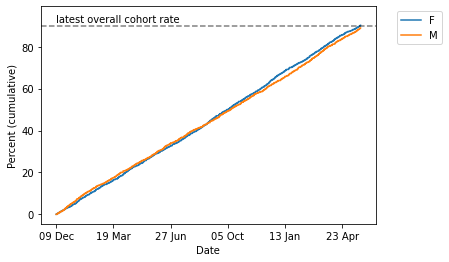

### COVID vaccinations among **80+** population by **ageband 5yr**

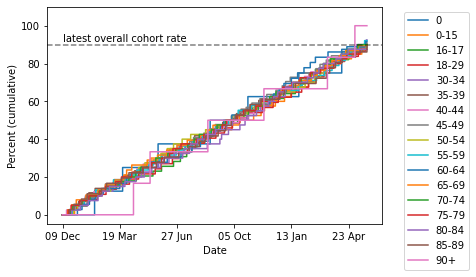

### COVID vaccinations among **80+** population by **ethnicity 6 groups**

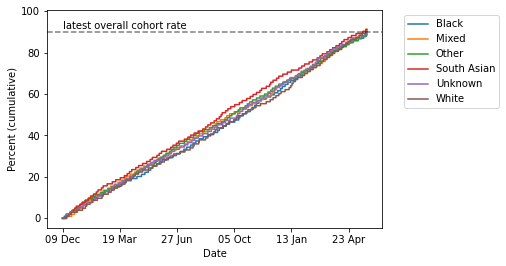

### COVID vaccinations among **80+** population by **imd categories**

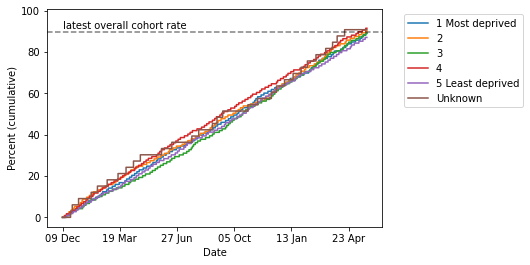

### COVID vaccinations among **80+** population by **bmi**

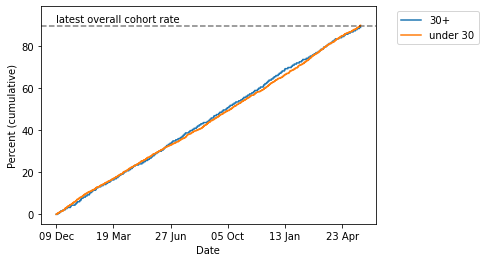

### COVID vaccinations among **80+** population by **housebound**

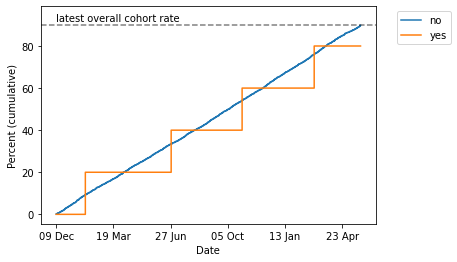

### COVID vaccinations among **80+** population by **dementia**

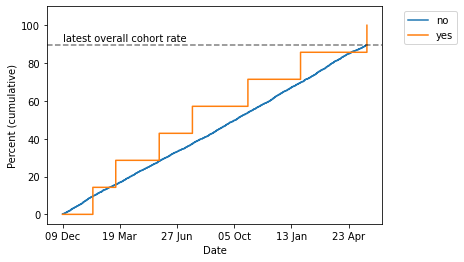

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

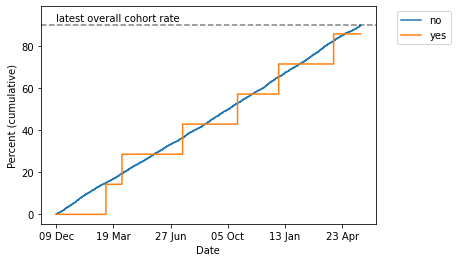

### COVID vaccinations among **80+** population by **LD**

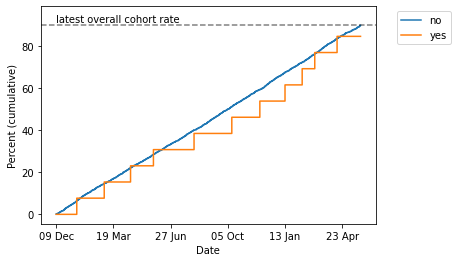

### COVID vaccinations among **80+** population by **ssri**

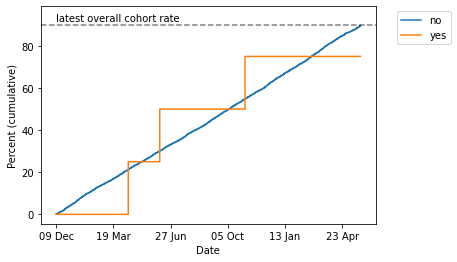

### COVID vaccinations among **80+** population by **ckd**

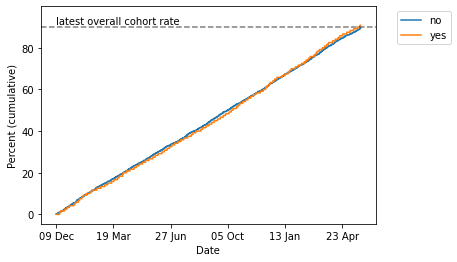

## 
 ## COVID vaccination rollout among **70-79** population up to 25 May 2022

### COVID vaccinations among **70-79** population by **sex**

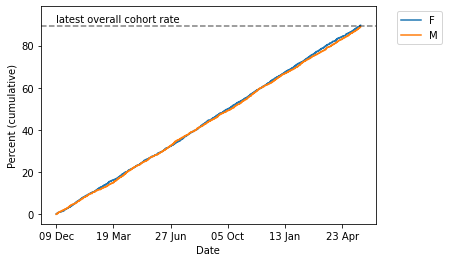

### COVID vaccinations among **70-79** population by **ageband 5yr**

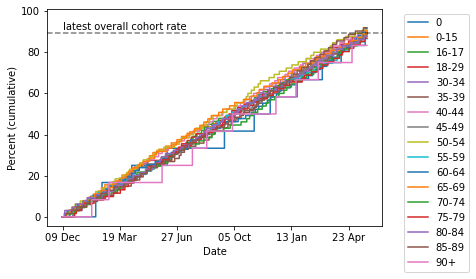

### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

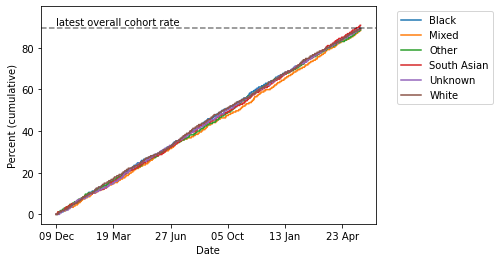

### COVID vaccinations among **70-79** population by **imd categories**

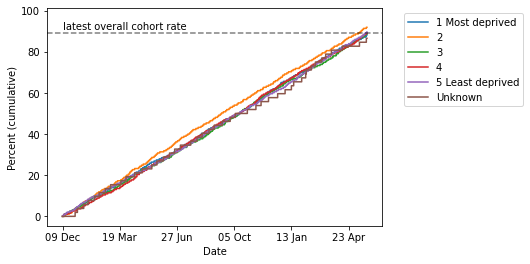

### COVID vaccinations among **70-79** population by **bmi**

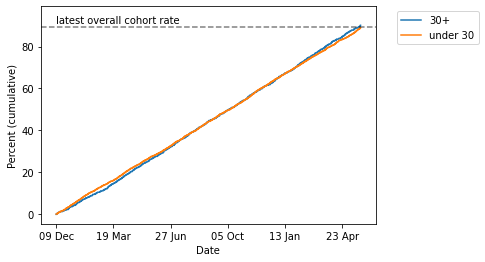

### COVID vaccinations among **70-79** population by **housebound**

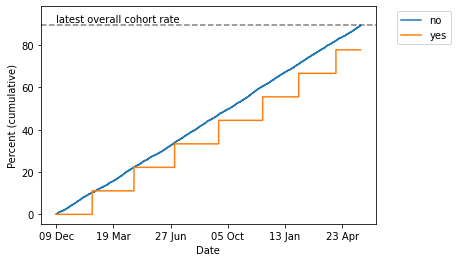

### COVID vaccinations among **70-79** population by **dementia**

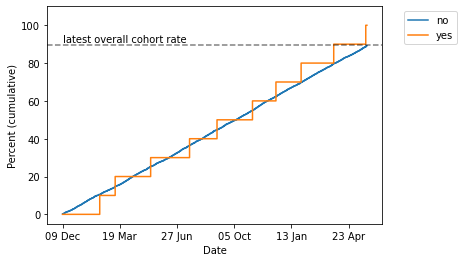

### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

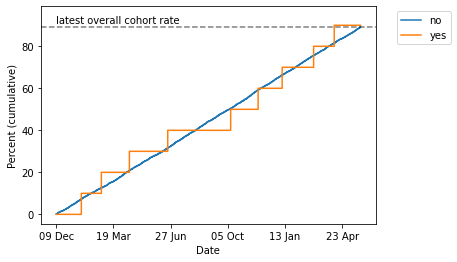

### COVID vaccinations among **70-79** population by **LD**

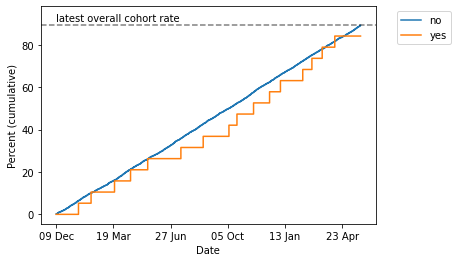

### COVID vaccinations among **70-79** population by **ssri**

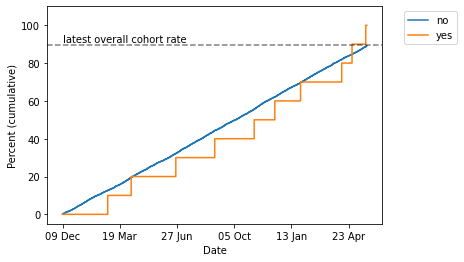

### COVID vaccinations among **70-79** population by **ckd**

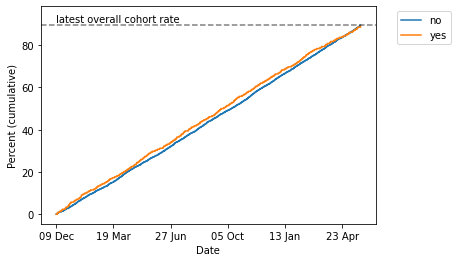

## 
 ## COVID vaccination rollout among **65-69** population up to 25 May 2022

### COVID vaccinations among **65-69** population by **sex**

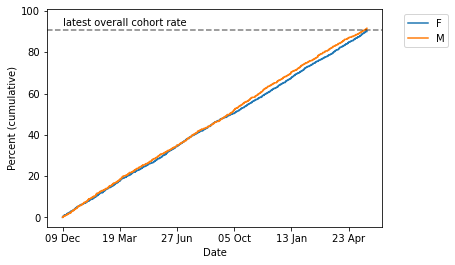

### COVID vaccinations among **65-69** population by **ethnicity 6 groups**

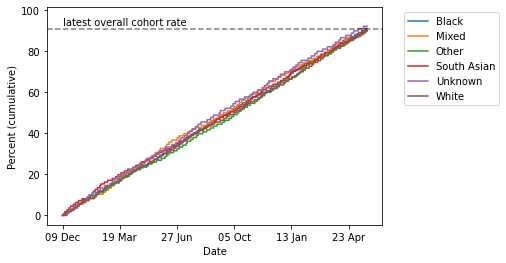

### COVID vaccinations among **65-69** population by **imd categories**

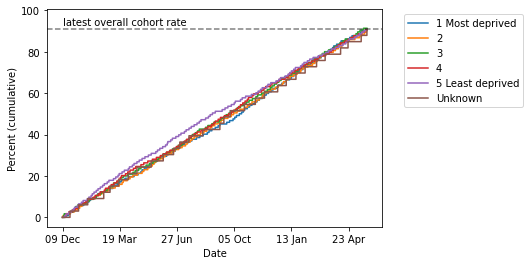

### COVID vaccinations among **65-69** population by **bmi**

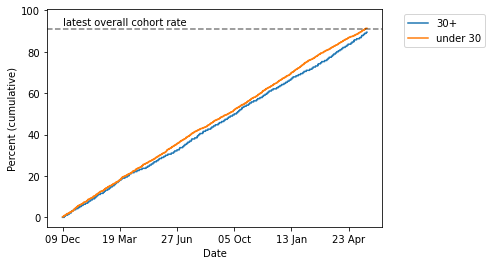

### COVID vaccinations among **65-69** population by **housebound**

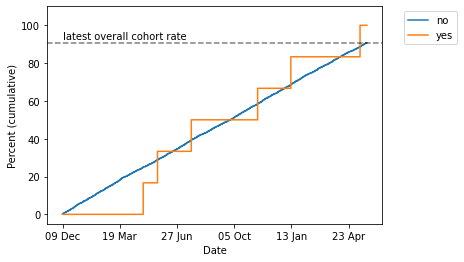

### COVID vaccinations among **65-69** population by **dementia**

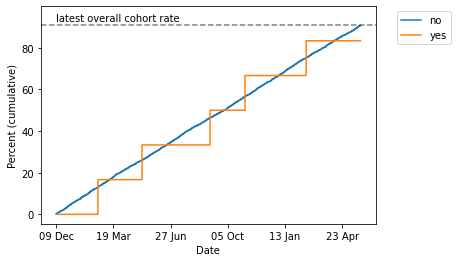

### COVID vaccinations among **65-69** population by **psychosis schiz bipolar**

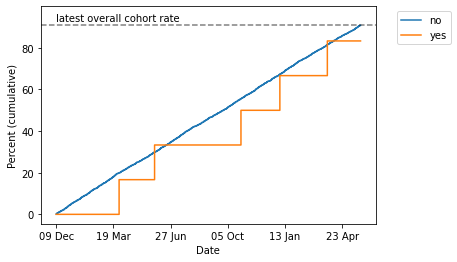

### COVID vaccinations among **65-69** population by **LD**

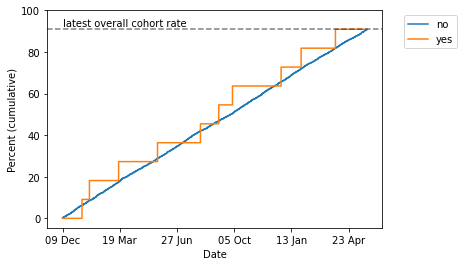

### COVID vaccinations among **65-69** population by **ssri**

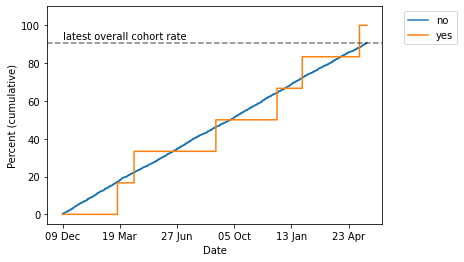

### COVID vaccinations among **65-69** population by **ckd**

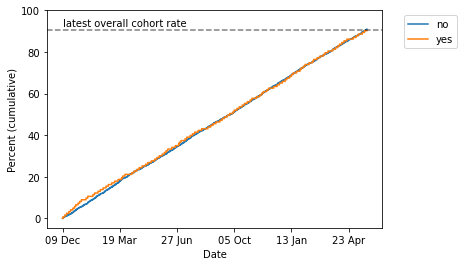

## 
 ## COVID vaccination rollout among **shielding (aged 16-69)** population up to 25 May 2022

### COVID vaccinations among **shielding (aged 16-69)** population by **newly shielded since feb 15**

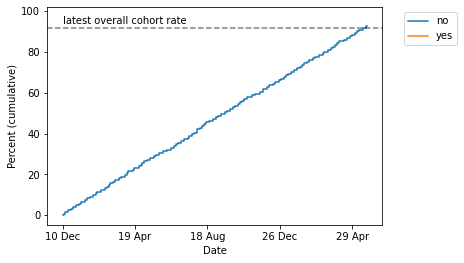

### COVID vaccinations among **shielding (aged 16-69)** population by **sex**

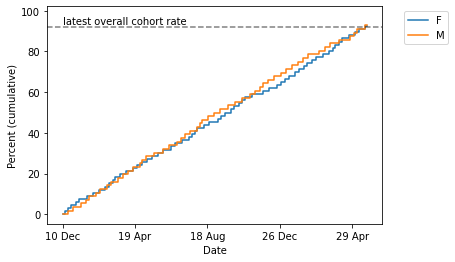

### COVID vaccinations among **shielding (aged 16-69)** population by **ageband**

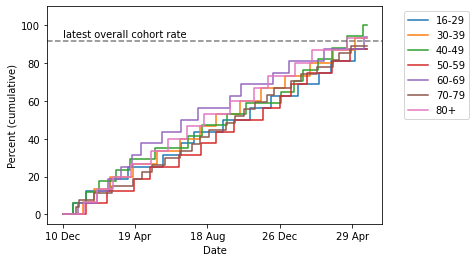

### COVID vaccinations among **shielding (aged 16-69)** population by **ethnicity 6 groups**

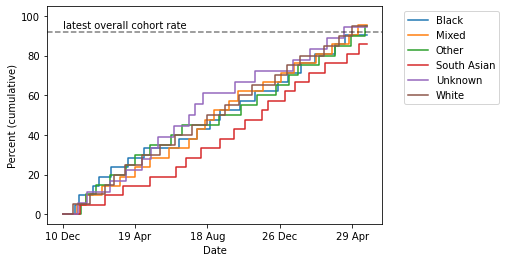

### COVID vaccinations among **shielding (aged 16-69)** population by **imd categories**

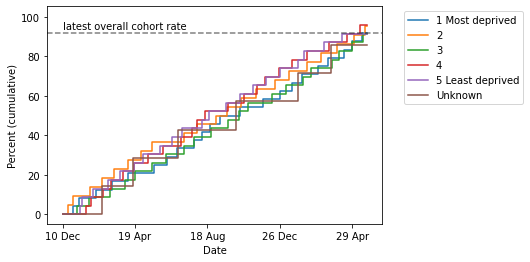

### COVID vaccinations among **shielding (aged 16-69)** population by **LD**

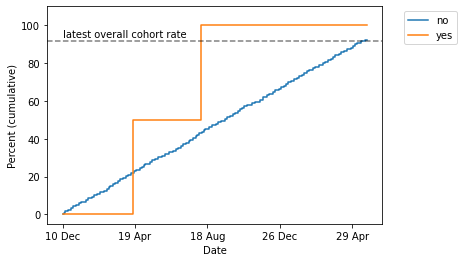

### COVID vaccinations among **shielding (aged 16-69)** population by **ckd**

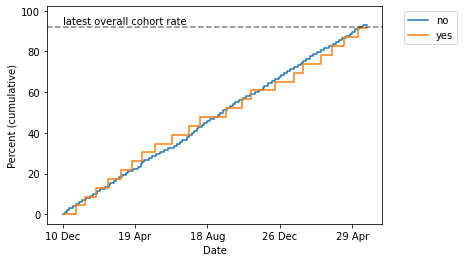

## 
 ## COVID vaccination rollout among **60-64** population up to 25 May 2022

### COVID vaccinations among **60-64** population by **sex**

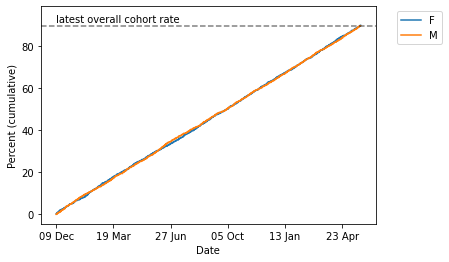

### COVID vaccinations among **60-64** population by **ethnicity 6 groups**

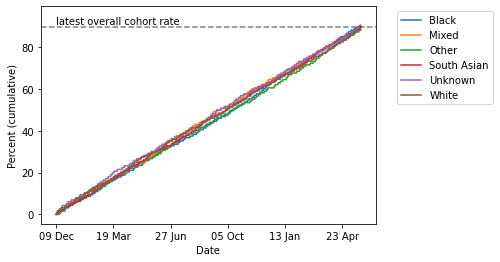

### COVID vaccinations among **60-64** population by **imd categories**

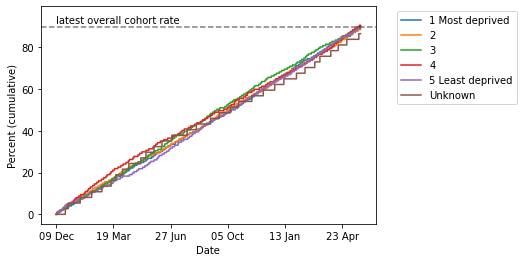

### COVID vaccinations among **60-64** population by **bmi**

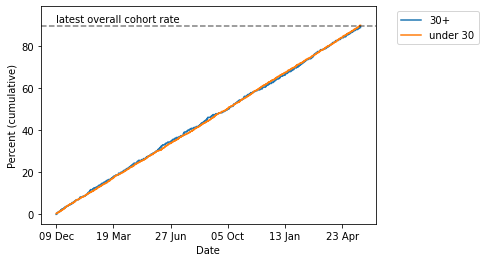

### COVID vaccinations among **60-64** population by **dementia**

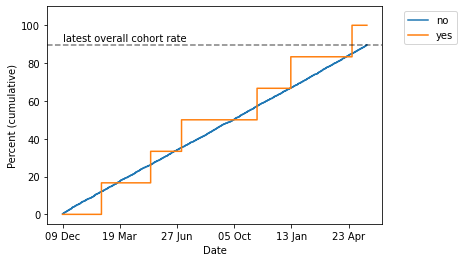

### COVID vaccinations among **60-64** population by **psychosis schiz bipolar**

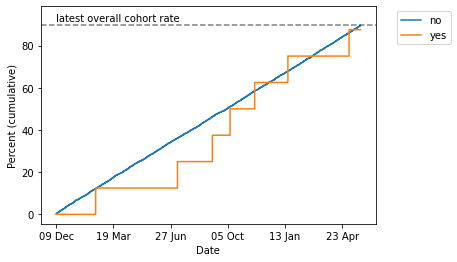

### COVID vaccinations among **60-64** population by **ssri**

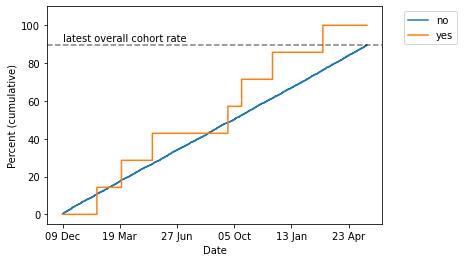

### COVID vaccinations among **60-64** population by **ckd**

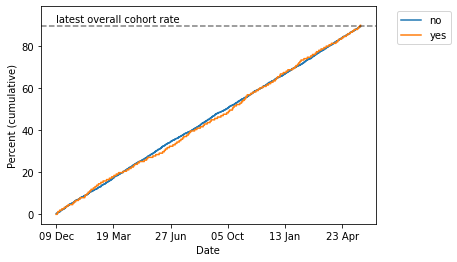

## 
 ## COVID vaccination rollout among **55-59** population up to 25 May 2022

### COVID vaccinations among **55-59** population by **sex**

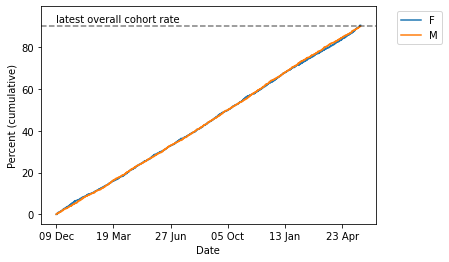

### COVID vaccinations among **55-59** population by **ethnicity 6 groups**

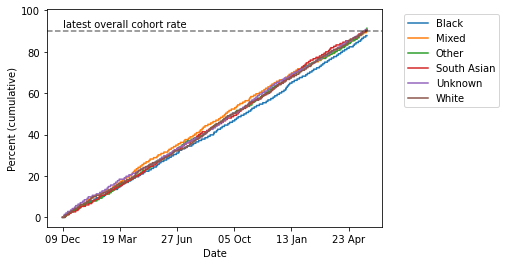

### COVID vaccinations among **55-59** population by **imd categories**

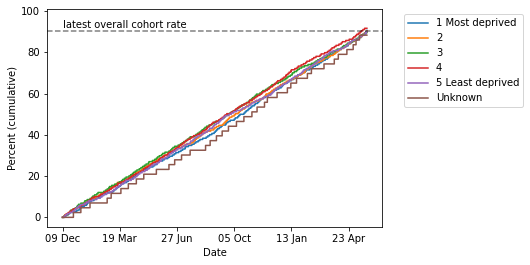

### COVID vaccinations among **55-59** population by **bmi**

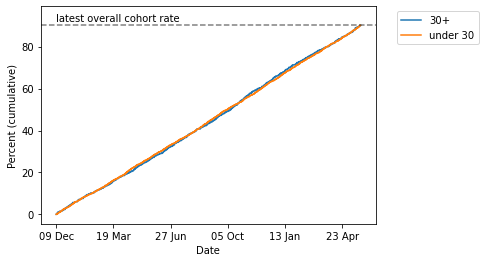

### COVID vaccinations among **55-59** population by **psychosis schiz bipolar**

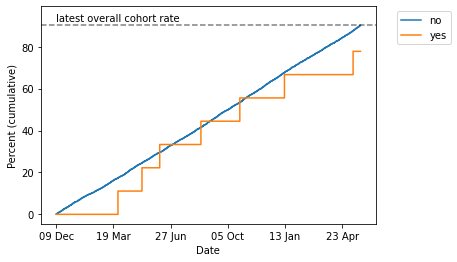

### COVID vaccinations among **55-59** population by **ssri**

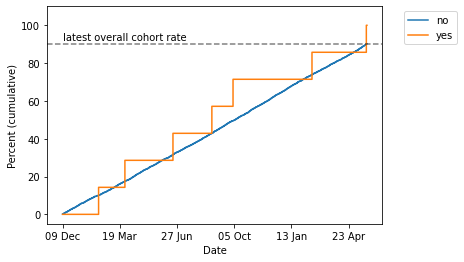

### COVID vaccinations among **55-59** population by **ckd**

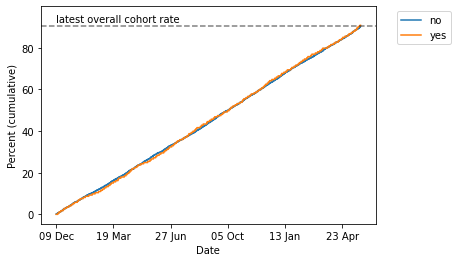

## 
 ## COVID vaccination rollout among **50-54** population up to 25 May 2022

### COVID vaccinations among **50-54** population by **sex**

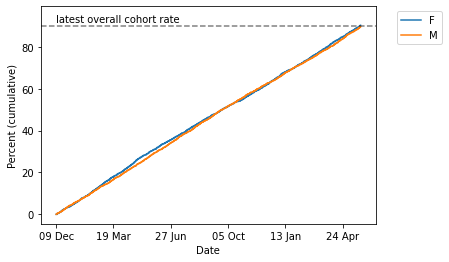

### COVID vaccinations among **50-54** population by **ethnicity 6 groups**

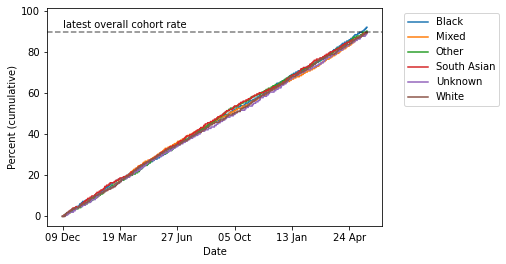

### COVID vaccinations among **50-54** population by **imd categories**

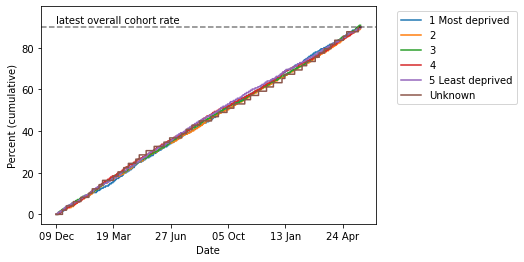

### COVID vaccinations among **50-54** population by **bmi**

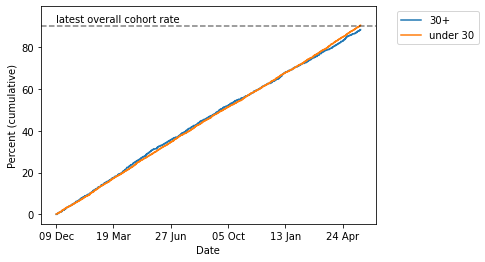

### COVID vaccinations among **50-54** population by **psychosis schiz bipolar**

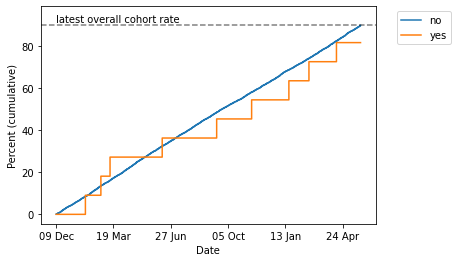

### COVID vaccinations among **50-54** population by **ssri**

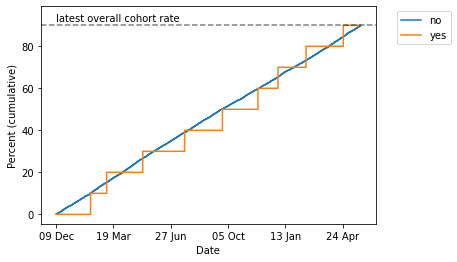

### COVID vaccinations among **50-54** population by **ckd**

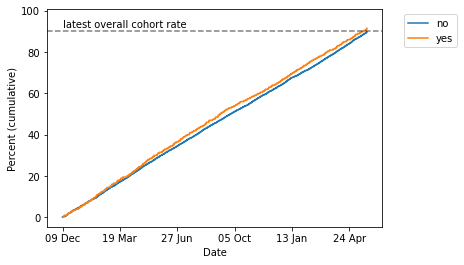

## 
 ## COVID vaccination rollout among **40-49** population up to 25 May 2022

### COVID vaccinations among **40-49** population by **sex**

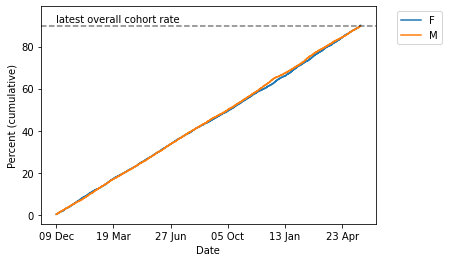

### COVID vaccinations among **40-49** population by **ethnicity 6 groups**

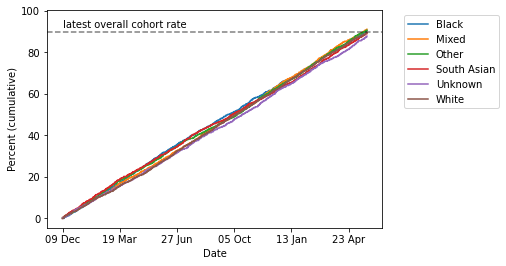

### COVID vaccinations among **40-49** population by **imd categories**

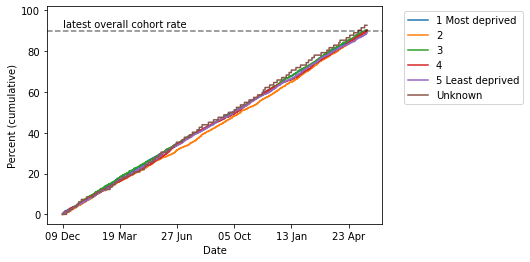

### COVID vaccinations among **40-49** population by **bmi**

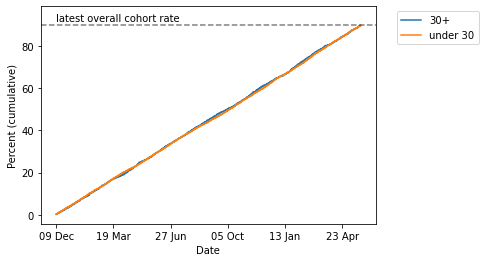

### COVID vaccinations among **40-49** population by **psychosis schiz bipolar**

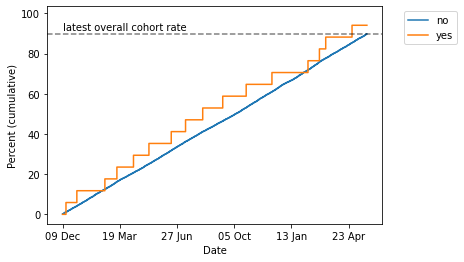

### COVID vaccinations among **40-49** population by **ssri**

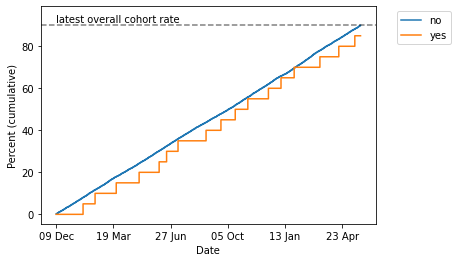

### COVID vaccinations among **40-49** population by **ckd**

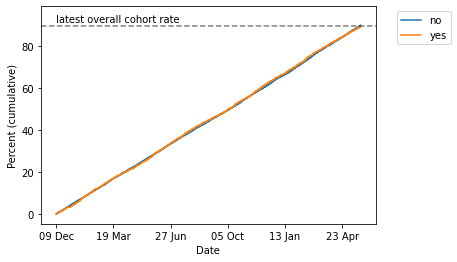

## 
 ## COVID vaccination rollout among **30-39** population up to 25 May 2022

### COVID vaccinations among **30-39** population by **sex**

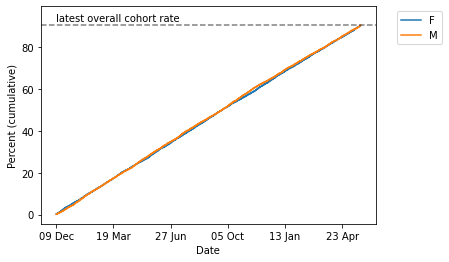

### COVID vaccinations among **30-39** population by **ethnicity 6 groups**

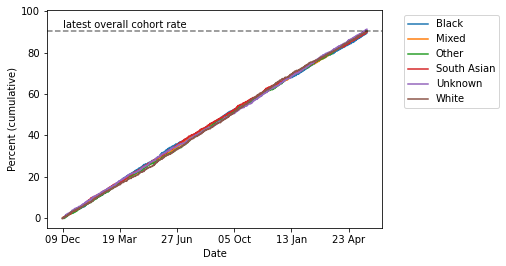

### COVID vaccinations among **30-39** population by **imd categories**

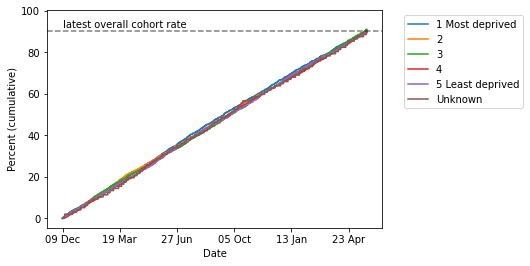

## 
 ## COVID vaccination rollout among **18-29** population up to 25 May 2022

### COVID vaccinations among **18-29** population by **sex**

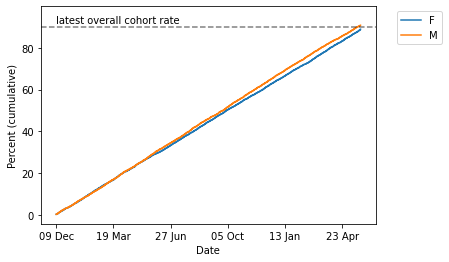

### COVID vaccinations among **18-29** population by **ethnicity 6 groups**

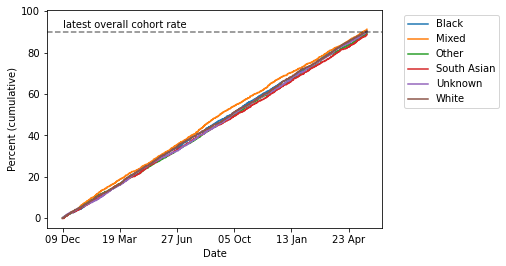

### COVID vaccinations among **18-29** population by **imd categories**

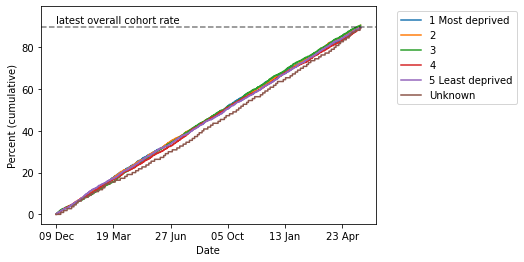

In [28]:


plot_dem_charts(summ_stat_results, df_dict_cum,  formatted_latest_date, pop_subgroups=["80+", "70-79", "65-69","shielding (aged 16-69)", "60-64", "55-59", "50-54", "40-49", "30-39", "18-29"], groups_dict=features_dict,
                groups_to_exclude=["ethnicity_16_groups", "current_copd", "chronic_cardiac_disease", "dmards", "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)


# ## Completeness of ethnicity recording

In [29]:


from data_quality import *

ethnicity_completeness(df=df, groups_of_interest=population_subgroups)


# # Second doses

Total **80+** population with ethnicity recorded 3,591 (84.7%)

Total **70-79** population with ethnicity recorded 5,978 (85.5%)

Total **care home** population with ethnicity recorded 2,380 (86.1%)

Total **shielding (aged 16-69)** population with ethnicity recorded 721 (84.4%)

Total **65-69** population with ethnicity recorded 3,703 (85.5%)

Total **LD (aged 16-64)** population with ethnicity recorded 1,386 (84.6%)

Total **60-64** population with ethnicity recorded 4,529 (84.9%)

Total **55-59** population with ethnicity recorded 5,299 (84.3%)

Total **50-54** population with ethnicity recorded 5,894 (85.1%)

Total **40-49** population with ethnicity recorded 10,465 (85.0%)

Total **30-39** population with ethnicity recorded 10,836 (84.9%)

Total **18-29** population with ethnicity recorded 12,544 (85.1%)

Total **16-17** population with ethnicity recorded 17,675 (85.0%)

In [30]:


# only count second doses where the first dose was given at least 14 weeks ago 
# to allow comparison of the first dose situation 14w ago with the second dose situation now
# otherwise bias could be introduced from any second doses given early in certain subgroups

def subtract_from_date(s, unit, number, description):
    '''
    s (series): a series of date-like strings
    unit (str) : days/weeks
    number (int): number of days/weeks to subtract
    description (str): description of new date calculated to use as filename
    '''
    if unit == "weeks":
        new_date = pd.to_datetime(s).max() - timedelta(weeks=number)
    elif unit == "days":
        new_date = pd.to_datetime(s).max() - timedelta(days=number)
    else:
        display("invalid unit")
        return
    new_date = str(new_date)[:10]

    formatted_date = datetime.strptime(new_date, "%Y-%m-%d").strftime("%d %b %Y")
    with open(os.path.join(savepath["text"], f"{description}.txt"), "w") as text_file:
            text_file.write(formatted_date)
    with open(os.path.join(savepath["text"], f"{description}_specified_delay.txt"), "w") as text_file:
        formatted_delay = f"{number} {unit}"
        text_file.write(formatted_delay)

    display(Markdown(formatted_date))
    return new_date, formatted_date
    

date_14w, formatted_date_14w = subtract_from_date(s=df["covid_vacc_date"], unit="weeks", number=14,
                                             description="latest_date_of_first_dose_for_due_second_doses")

16 Feb 2022

In [31]:


# filter data
df_s = df.copy()
# replace any second doses not yet "due" with "0"
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) >= date_14w), "covid_vacc_second_dose_date"] = 0

# also ensure that first dose was dated after the start of the campaign, otherwise date is likely incorrect 
# and due date for second dose cannot be calculated accurately
# this also excludes any second doses where first dose date = 0 (this should affect dummy data only!)
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_second_dose_date"] = 0

In [32]:


# add "brand of first dose" to list of features to break down by
import copy
features_dict_2 = copy.deepcopy(features_dict)

for k in features_dict_2:
    ls = list(features_dict_2[k])
    ls.append("brand_of_first_dose") 
    features_dict_2[k] = ls

In [33]:


# data processing / summarising
df_dict_cum_second_dose = cumulative_sums(df_s, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

second_dose_summarised_data_dict = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

create_detailed_summary_uptake(second_dose_summarised_data_dict, formatted_latest_date, 
                               groups=groups,
                               savepath=savepath, vaccine_type="second_dose")

# ## For comparison look at first doses UP TO 14 WEEKS AGO
#

## 

## COVID vaccination rollout (second dose) among **80+** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2478   
sex                       F                                          1260   
                          M                                          1218   
ageband_5yr               0                                            35   
                          0-15                                        161   
                          16-17                                       154   
                          18-29                                       154   
                          30-34                                       168   
                          35-39                                       175   
                          40-44                                       175   
                          45-49                                       189   
                          50-54                                       154   
                          55-59                                       147   
                          60-64                                       154   
                          65-69                                       147   
                          70-74                                       161   
                          75-79                                       168   
                          80-84                                       168   
                          85-89                                       140   
                          90+                                          21   
ethnicity_6_groups        Black                                       406   
                          Mixed                                       406   
                          Other                                       441   
                          South Asian                                 434   
                          Unknown                                     378   
                          White                                       413   
ethnicity_16_groups        African                                    119   
                           Bangladeshi or British Bangladeshi         133   
                           Caribbean                                  140   
                           Chinese                                    126   
                           Other                                      126   
                           Other Asian                                126   
                          British or Mixed British                    140   
                          Indian or British Indian                    133   
                          Irish                                       140   
                          Other Black                                 140   
                          Other White                                 126   
                          Other mixed                                 133   
                          Pakistani or British Pakistani              119   
                          Unknown                                     385   
                          White + Asian                               133   
                          White + Black African                       126   
                          White + Black Caribbean                     140   
imd_categories            1 Most deprived                             462   
                          2                                           455   
                          3                                           476   
                          4                                           497   
                          5 Least deprived                            441   
                          Unknown                                     154   
bmi                       30+                                         756   
                          under 30                         

## 

## COVID vaccination rollout (second dose) among **70-79** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    4109   
sex                       F                                          2065   
                          M                                          2044   
ageband_5yr               0                                            49   
                          0-15                                        273   
                          16-17                                       252   
                          18-29                                       266   
                          30-34                                       266   
                          35-39                                       273   
                          40-44                                       287   
                          45-49                                       294   
                          50-54                                       287   
                          55-59                                       266   
                          60-64                                       252   
                          65-69                                       266   
                          70-74                                       252   
                          75-79                                       245   
                          80-84                                       273   
                          85-89                                       266   
                          90+                                          42   
ethnicity_6_groups        Black                                       693   
                          Mixed                                       707   
                          Other                                       679   
                          South Asian                                 714   
                          Unknown                                     595   
                          White                                       721   
ethnicity_16_groups        African                                    217   
                           Bangladeshi or British Bangladeshi         231   
                           Caribbean                                  203   
                           Chinese                                    224   
                           Other                                      224   
                           Other Asian                                231   
                          British or Mixed British                    224   
                          Indian or British Indian                    217   
                          Irish                                       217   
                          Other Black                                 217   
                          Other White                                 217   
                          Other mixed                                 217   
                          Pakistani or British Pakistani              210   
                          Unknown                                     616   
                          White + Asian                               196   
                          White + Black African                       203   
                          White + Black Caribbean                     224   
imd_categories            1 Most deprived                             756   
                          2                                           777   
                          3                                           805   
                          4                                           784   
                          5 Least deprived                            770   
                          Unknown                                     210   
bmi                       30+                                        1267   
                          under 30                         

## 

## COVID vaccination rollout (second dose) among **care home** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall            1659     60.0   2765   
sex                 F                   854     61.6   1386   
                    M                   805     58.4   1379   
ageband_5yr         0                    14     40.0     35   
                    0-15                112     61.5    182   
                    16-17                98     63.6    154   
                    18-29               112     57.1    196   
                    30-34               105     60.0    175   
                    35-39                98     56.0    175   
                    40-44               112     64.0    175   
                    45-49               105     57.7    182   
                    50-54               133     61.3    217   
                    55-59               105     55.6    189   
                    60-64               126     66.7    189   
                    65-69                91     54.2    168   
                    70-74                98     58.3    168   
                    75-79               133     70.4    189   
                    80-84               105     60.0    175   
                    85-89                91     54.2    168   
                    90+                  14     50.0     28   
ethnicity_6_groups  Black               273     58.2    469   
                    Mixed               287     62.1    462   
                    Other               280     60.6    462   
                    South Asian         294     58.3    504   
                    Unknown             231     58.9    392   
                    White               287     59.4    483   
dementia            no                 1638     59.8   2737   
                    yes                  21     75.0     28   
brand_of_first_dose Pfizer                0      0.0      0   
                    Unknown            1652     66.5   2485   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 59.0   
sex                 F                                       60.6   
                    M                                       57.4   
ageband_5yr         0                                       40.0   
                    0-15                                    61.5   
                    16-17                                   63.6   
                    18-29                                   57.1   
                    30-34                                   60.0   
                    35-39                                   52.0   
                    40-44                                   64.0   
                    45-49                                   57.7   
                    50-54                                   61.3   
                    55-59                                   55.6   
                    60-64                                   66.7   
                    65-69                                   54.2   
                    70-74                                   54.2   
                    75-79                                   66.7   
                    80-84                                   60.0   
                    85-89                                   54.2   
                    90+                                     50.0   
ethnicity_6_groups  Black                                   56.7   
                    Mixed                                   60.6   
                    Other                                   60.6   
                    South Asian                             56.9   
                    Unknown                                 58.9   
                    White                                   58.0   
dementia            no                                      58.8   
                    yes                     

## 

## COVID vaccination rollout (second dose) among **shielding (aged 16-69)** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  518     60.7    854   
newly_shielded_since_feb_15 no                       518     61.2    847   
                            yes                        0      0.0      0   
sex                         F                        280     60.6    462   
                            M                        238     60.7    392   
ageband                     16-29                     56     50.0    112   
                            30-39                     70     66.7    105   
                            40-49                     70     58.8    119   
                            50-59                     70     62.5    112   
                            60-69                     77     68.8    112   
                            70-79                    112     59.3    189   
                            80+                       70     66.7    105   
ethnicity_6_groups          Black                     91     61.9    147   
                            Mixed                     91     61.9    147   
                            Other                     84     60.0    140   
                            South Asian               84     57.1    147   
                            Unknown                   84     66.7    126   
                            White                     84     60.0    140   
imd_categories              1 Most deprived           98     58.3    168   
                            2                         91     59.1    154   
                            3                         91     56.5    161   
                            4                        105     65.2    161   
                            5 Least deprived         112     69.6    161   
                            Unknown                   28     57.1     49   
LD                          no                       511     61.3    833   
                            yes                       14    100.0     14   
ckd                         no                       420     61.2    686   
                            yes                       98     60.9    161   
brand_of_first_dose         Oxford-AZ                  0      0.0      0   
                            Unknown                  518     66.1    784   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      59.8   
newly_shielded_since_feb_15 no                                           60.3   
                            yes                                           NaN   
sex                         F                                            60.6   
                            M                                            60.7   
ageband                     16-29                                        50.0   
                            30-39                                        66.7   
                            40-49                                        58.8   
                            50-59                                        62.5   
                            60-69                                        62.5   
                            70-79                                        59.3   
                            80+                                          66.7   
ethnicity_6_groups          Black                                        61.9   
                            Mixed                                        61.9   
                            Other                                        60.0   
                            South Asian                                  57.1   
                            Unknown                                      66.7   
                            White                                        6

## 

## COVID vaccination rollout (second dose) among **65-69** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2604   
sex                       F                                          1309   
                          M                                          1295   
ethnicity_6_groups        Black                                       441   
                          Mixed                                       413   
                          Other                                       455   
                          South Asian                                 462   
                          Unknown                                     399   
                          White                                       441   
ethnicity_16_groups        African                                    140   
                           Bangladeshi or British Bangladeshi         140   
                           Caribbean                                  126   
                           Chinese                                    133   
                           Other                                      140   
                           Other Asian                                119   
                          British or Mixed British                    126   
                          Indian or British Indian                    147   
                          Irish                                       140   
                          Other Black                                 168   
                          Other White                                 133   
                          Other mixed                                 154   
                          Pakistani or British Pakistani              147   
                          Unknown                                     371   
                          White + Asian                               133   
                          White + Black African                       147   
                          White + Black Caribbean                     147   
imd_categories            1 Most deprived                             497   
                          2                                           476   
                          3                                           497   
                          4                                           476   
                          5 Least deprived                            525   
                          Unknown                                     133   
bmi                       30+                                         777   
                          under 30                                   1827   
housebound                no                                         2576   
                          yes                                          28   
chronic_cardiac_disease   no                                         2583   
                          yes                                          21   
current_copd              no                                         2576   
                          yes                                          28   
dmards                    no                                         2590   
                          yes                                          14   
dementia                  no                                         2576   
                          yes                                          21   
psychosis_schiz_bipolar   no                                         2583   
                          yes                                          21   
LD                        no                                         2555   
                          yes                                          49   
ssri                      no                                         2576   
                          yes                                          28   
chemo_or_radio            no                               

## 

## COVID vaccination rollout (second dose) among **LD (aged 16-64)** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             952     58.1   1638   
sex                 F                   476     57.1    833   
                    M                   476     59.1    805   
ageband_5yr         0                    14     66.7     21   
                    0-15                 56     53.3    105   
                    16-17                63     56.2    112   
                    18-29                63     64.3     98   
                    30-34                70     66.7    105   
                    35-39                63     64.3     98   
                    40-44                63     60.0    105   
                    45-49                63     60.0    105   
                    50-54                56     53.3    105   
                    55-59                63     56.2    112   
                    60-64                49     46.7    105   
                    65-69                63     56.2    112   
                    70-74                56     53.3    105   
                    75-79                63     60.0    105   
                    80-84                63     60.0    105   
                    85-89                63     56.2    112   
                    90+                  14     66.7     21   
ethnicity_6_groups  Black               161     56.1    287   
                    Mixed               147     55.3    266   
                    Other               161     59.0    273   
                    South Asian         168     63.2    266   
                    Unknown             147     58.3    252   
                    White               168     57.1    294   
brand_of_first_dose Unknown             952     65.7   1449   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 57.3   
sex                 F                                       56.3   
                    M                                       59.1   
ageband_5yr         0                                       66.7   
                    0-15                                    53.3   
                    16-17                                   56.2   
                    18-29                                   64.3   
                    30-34                                   66.7   
                    35-39                                   64.3   
                    40-44                                   60.0   
                    45-49                                   60.0   
                    50-54                                   53.3   
                    55-59                                   56.2   
                    60-64                                   46.7   
                    65-69                                   56.2   
                    70-74                                   53.3   
                    75-79                                   53.3   
                    80-84                                   60.0   
                    85-89                                   50.0   
                    90+                                     66.7   
ethnicity_6_groups  Black                                   56.1   
                    Mixed                                   55.3   
                    Other                                   59.0   
                    South Asian                             63.2   
                    Unknown                                 55.6   
                    White                                   54.8   
brand_of_first_dose Unknown                                 64.7   

                                Uptake over last 7d (percent)  \
category            group                                       
overall             overall                               0.8   
sex                 F                

## 

## COVID vaccination rollout (second dose) among **60-64** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3087   
sex                       F                                          1519   
                          M                                          1561   
ethnicity_6_groups        Black                                       525   
                          Mixed                                       539   
                          Other                                       490   
                          South Asian                                 546   
                          Unknown                                     476   
                          White                                       511   
ethnicity_16_groups        African                                    175   
                           Bangladeshi or British Bangladeshi         133   
                           Caribbean                                  168   
                           Chinese                                    168   
                           Other                                      168   
                           Other Asian                                175   
                          British or Mixed British                    161   
                          Indian or British Indian                    168   
                          Irish                                       154   
                          Other Black                                 161   
                          Other White                                 154   
                          Other mixed                                 189   
                          Pakistani or British Pakistani              161   
                          Unknown                                     455   
                          White + Asian                               168   
                          White + Black African                       175   
                          White + Black Caribbean                     154   
imd_categories            1 Most deprived                             609   
                          2                                           588   
                          3                                           630   
                          4                                           553   
                          5 Least deprived                            560   
                          Unknown                                     147   
bmi                       30+                                         938   
                          under 30                                   2149   
chronic_cardiac_disease   no                                         3052   
                          yes                                          28   
current_copd              no                                         3052   
                          yes                                          28   
dmards                    no                                         3059   
                          yes                                          28   
dementia                  no                                         3059   
                          yes                                          28   
psychosis_schiz_bipolar   no                                         3045   
                          yes                                          35   
ssri                      no                                         3052   
                          yes                                          28   
chemo_or_radio            no                                         3052   
                          yes                                          35   
lung_cancer               no                                         3045   
                          yes                                          35   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (second dose) among **55-59** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    3682   
sex                     F                                          1841   
                        M                                          1834   
ethnicity_6_groups      Black                                       595   
                        Mixed                                       616   
                        Other                                       616   
                        South Asian                                 609   
                        Unknown                                     574   
                        White                                       665   
ethnicity_16_groups      African                                    210   
                         Bangladeshi or British Bangladeshi         210   
                         Caribbean                                  168   
                         Chinese                                    182   
                         Other                                      203   
                         Other Asian                                168   
                        British or Mixed British                    175   
                        Indian or British Indian                    217   
                        Irish                                       210   
                        Other Black                                 203   
                        Other White                                 203   
                        Other mixed                                 203   
                        Pakistani or British Pakistani              196   
                        Unknown                                     532   
                        White + Asian                               224   
                        White + Black African                       196   
                        White + Black Caribbean                     182   
imd_categories          1 Most deprived                             672   
                        2                                           721   
                        3                                           728   
                        4                                           721   
                        5 Least deprived                            672   
                        Unknown                                     168   
bmi                     30+                                        1078   
                        under 30                                   2597   
chronic_cardiac_disease no                                         3647   
                        yes                                          28   
current_copd            no                                         3647   
                        yes                                          35   
dmards                  no                                         3640   
                        yes                                          42   
psychosis_schiz_bipolar no                                         3647   
                        yes                                          35   
ssri                    no                                         3647   
                        yes                                          28   
ckd                     no                                         2961   
                        yes                                         721   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    3675   

                                                             percent  total  \
category                group                                                 
ov

## 

## COVID vaccination rollout (second dose) among **50-54** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    4011   
sex                     F                                          2023   
                        M                                          1995   
ethnicity_6_groups      Black                                       679   
                        Mixed                                       693   
                        Other                                       672   
                        South Asian                                 707   
                        Unknown                                     581   
                        White                                       679   
ethnicity_16_groups      African                                    231   
                         Bangladeshi or British Bangladeshi         196   
                         Caribbean                                  217   
                         Chinese                                    203   
                         Other                                      231   
                         Other Asian                                217   
                        British or Mixed British                    203   
                        Indian or British Indian                    231   
                        Irish                                       203   
                        Other Black                                 217   
                        Other White                                 224   
                        Other mixed                                 217   
                        Pakistani or British Pakistani              224   
                        Unknown                                     567   
                        White + Asian                               210   
                        White + Black African                       210   
                        White + Black Caribbean                     203   
imd_categories          1 Most deprived                             784   
                        2                                           749   
                        3                                           791   
                        4                                           756   
                        5 Least deprived                            749   
                        Unknown                                     189   
bmi                     30+                                        1225   
                        under 30                                   2793   
chronic_cardiac_disease no                                         3976   
                        yes                                          35   
current_copd            no                                         3969   
                        yes                                          42   
dmards                  no                                         3983   
                        yes                                          28   
psychosis_schiz_bipolar no                                         3976   
                        yes                                          42   
ssri                    no                                         3976   
                        yes                                          42   
ckd                     no                                         3178   
                        yes                                         833   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    4004   

                                                             percent  total  \
category                group                                                 
ov

## 

## COVID vaccination rollout (second dose) among **40-49** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    7182   
sex                     F                                          3661   
                        M                                          3514   
ethnicity_6_groups      Black                                      1218   
                        Mixed                                      1211   
                        Other                                      1239   
                        South Asian                                1239   
                        Unknown                                    1036   
                        White                                      1239   
ethnicity_16_groups      African                                    385   
                         Bangladeshi or British Bangladeshi         392   
                         Caribbean                                  392   
                         Chinese                                    357   
                         Other                                      385   
                         Other Asian                                392   
                        British or Mixed British                    399   
                        Indian or British Indian                    399   
                        Irish                                       385   
                        Other Black                                 350   
                        Other White                                 399   
                        Other mixed                                 364   
                        Pakistani or British Pakistani              364   
                        Unknown                                    1078   
                        White + Asian                               392   
                        White + Black African                       371   
                        White + Black Caribbean                     371   
imd_categories          1 Most deprived                            1379   
                        2                                          1323   
                        3                                          1393   
                        4                                          1358   
                        5 Least deprived                           1379   
                        Unknown                                     357   
bmi                     30+                                        2191   
                        under 30                                   4991   
chronic_cardiac_disease no                                         7112   
                        yes                                          70   
current_copd            no                                         7098   
                        yes                                          84   
dmards                  no                                         7112   
                        yes                                          70   
psychosis_schiz_bipolar no                                         7112   
                        yes                                          70   
ssri                    no                                         7105   
                        yes                                          70   
ckd                     no                                         5726   
                        yes                                        1456   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        7   
                        Unknown                                    7161   

                                                             percent  total  \
category                group                                                 
ov

## 

## COVID vaccination rollout (second dose) among **30-39** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    7567     59.3   
sex                 F                                          3927     59.4   
                    M                                          3640     59.1   
ethnicity_6_groups  Black                                      1316     60.3   
                    Mixed                                      1267     58.6   
                    Other                                      1309     59.6   
                    South Asian                                1274     58.3   
                    Unknown                                    1148     59.6   
                    White                                      1253     59.5   
ethnicity_16_groups  African                                    399     60.0   
                     Bangladeshi or British Bangladeshi         413     60.2   
                     Caribbean                                  406     59.8   
                     Chinese                                    392     57.7   
                     Other                                      427     60.4   
                     Other Asian                                392     58.3   
                    British or Mixed British                    413     60.8   
                    Indian or British Indian                    406     61.1   
                    Irish                                       413     62.1   
                    Other Black                                 399     57.6   
                    Other White                                 413     61.5   
                    Other mixed                                 413     59.0   
                    Pakistani or British Pakistani              385     56.7   
                    Unknown                                    1127     58.3   
                    White + Asian                               392     58.9   
                    White + Black African                       399     58.2   
                    White + Black Caribbean                     371     57.0   
imd_categories      1 Most deprived                            1470     60.0   
                    2                                          1421     59.2   
                    3                                          1477     59.9   
                    4                                          1351     57.4   
                    5 Least deprived                           1435     59.4   
                    Unknown                                     406     59.8   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        7    100.0   
                    Unknown                                    7553     65.7   

                                                         total  \
category            group                                        
overall             overall                              12761   
sex                 F                                     6608   
                    M                                     6160   
ethnicity_6_groups  Black                                 2184   
                    Mixed                                 2163   
                    Other                                 2198   
                    South Asian                           2184   
                    Unknown                               1925   
                    White                                 2107   
ethnicity_16_groups  African                               665   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             679   
                     Chinese                               679   
                     Other

## 

## COVID vaccination rollout (second dose) among **18-29** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    8638     58.6   
sex                 F                                          4284     57.3   
                    M                                          4354     59.9   
ethnicity_6_groups  Black                                      1498     58.5   
                    Mixed                                      1491     60.2   
                    Other                                      1456     58.3   
                    South Asian                                1449     58.0   
                    Unknown                                    1302     59.4   
                    White                                      1456     58.1   
ethnicity_16_groups  African                                    504     60.5   
                     Bangladeshi or British Bangladeshi         462     58.9   
                     Caribbean                                  420     57.7   
                     Chinese                                    483     60.5   
                     Other                                      427     57.5   
                     Other Asian                                427     56.5   
                    British or Mixed British                    462     58.9   
                    Indian or British Indian                    427     58.1   
                    Irish                                       462     57.4   
                    Other Black                                 483     59.0   
                    Other White                                 476     59.6   
                    Other mixed                                 476     61.3   
                    Pakistani or British Pakistani              399     54.3   
                    Unknown                                    1309     58.4   
                    White + Asian                               476     59.6   
                    White + Black African                       476     59.6   
                    White + Black Caribbean                     469     58.3   
imd_categories      1 Most deprived                            1610     58.4   
                    2                                          1680     59.4   
                    3                                          1666     58.9   
                    4                                          1603     58.6   
                    5 Least deprived                           1645     58.5   
                    Unknown                                     434     56.4   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     7     50.0   
                    Pfizer                                       14    100.0   
                    Unknown                                    8624     65.3   

                                                         total  \
category            group                                        
overall             overall                              14742   
sex                 F                                     7476   
                    M                                     7266   
ethnicity_6_groups  Black                                 2562   
                    Mixed                                 2478   
                    Other                                 2499   
                    South Asian                           2499   
                    Unknown                               2191   
                    White                                 2506   
ethnicity_16_groups  African                               833   
                     Bangladeshi or British Bangladeshi    784   
                     Caribbean                             728   
                     Chinese                               798   
                     Other

## 

## COVID vaccination rollout (second dose) among **16-17** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                          
overall             overall                12201     58.6  20804   
sex                 F                       6097     58.1  10500   
                    M                       6104     59.2  10304   
ethnicity_6_groups  Black                   2072     58.0   3570   
                    Mixed                   2037     58.3   3493   
                    Other                   2058     59.2   3479   
                    South Asian             2093     58.3   3591   
                    Unknown                 1869     59.7   3129   
                    White                   2079     58.6   3549   
imd_categories      1 Most deprived         2289     57.8   3962   
                    2                       2296     57.6   3983   
                    3                       2338     60.7   3850   
                    4                       2317     58.7   3948   
                    5 Least deprived        2352     57.9   4060   
                    Unknown                  602     60.1   1001   
brand_of_first_dose Moderna                    7     50.0     14   
                    Oxford-AZ                  7     50.0     14   
                    Pfizer                    14     50.0     28   
                    Unknown                12166     65.1  18697   

                                     vaccinated 7d previous (percent)  \
category            group                                               
overall             overall                                      57.9   
sex                 F                                            57.3   
                    M                                            58.5   
ethnicity_6_groups  Black                                        57.3   
                    Mixed                                        57.3   
                    Other                                        58.6   
                    South Asian                                  57.5   
                    Unknown                                      58.8   
                    White                                        57.8   
imd_categories      1 Most deprived                              57.1   
                    2                                            56.9   
                    3                                            60.0   
                    4                                            58.0   
                    5 Least deprived                             57.1   
                    Unknown                                      59.4   
brand_of_first_dose Moderna                                      50.0   
                    Oxford-AZ                                    50.0   
                    Pfizer                                       50.0   
                    Unknown                                      64.2   

                                     Uptake over last 7d (percent)  \
category            group                                            
overall             overall                                    0.7   
sex                 F                                          0.8   
                    M                                          0.7   
ethnicity_6_groups  Black                                      0.7   
                    Mixed                                      1.0   
                    Other                                      0.6   
                    South Asian                                0.8   
                    Unknown                                    0.9   
                    White                                      0.8   
imd_categories      1 Most deprived                            0.7   
                    2                                          0.7   
                    3                                          0.7   
                    4                                          0.7   
                    5 Lea

In [34]:


# latest date of 14 weeks ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that first dose was dated after the start of the campaign, 
# to be consistent with the second doses due calculated above
df_14w = df.copy()
df_14w.loc[(pd.to_datetime(df_14w["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_date"] = 0


df_dict_cum_14w = cumulative_sums(
                                  df_14w, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                  latest_date=date_14w
                                  )

summarised_data_dict_14w = summarise_data_by_group(
                                                   df_dict_cum_14w, 
                                                   latest_date=date_14w, 
                                                   groups=groups
                                                   )

create_detailed_summary_uptake(summarised_data_dict_14w, formatted_latest_date=date_14w, 
                               groups=groups,
                               savepath=savepath, vaccine_type="first_dose_14w_ago")


# # Booster/third doses

## 

## COVID vaccination rollout (first dose 14w ago) among **80+** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3094   
sex                       F                                          1589   
                          M                                          1498   
ageband_5yr               0                                            42   
                          0-15                                        196   
                          16-17                                       196   
                          18-29                                       182   
                          30-34                                       203   
                          35-39                                       224   
                          40-44                                       217   
                          45-49                                       231   
                          50-54                                       196   
                          55-59                                       189   
                          60-64                                       203   
                          65-69                                       189   
                          70-74                                       210   
                          75-79                                       210   
                          80-84                                       203   
                          85-89                                       175   
                          90+                                          28   
ethnicity_6_groups        Black                                       504   
                          Mixed                                       518   
                          Other                                       539   
                          South Asian                                 539   
                          Unknown                                     476   
                          White                                       518   
ethnicity_16_groups        African                                    147   
                           Bangladeshi or British Bangladeshi         161   
                           Caribbean                                  161   
                           Chinese                                    168   
                           Other                                      161   
                           Other Asian                                161   
                          British or Mixed British                    168   
                          Indian or British Indian                    175   
                          Irish                                       175   
                          Other Black                                 182   
                          Other White                                 154   
                          Other mixed                                 161   
                          Pakistani or British Pakistani              147   
                          Unknown                                     469   
                          White + Asian                               161   
                          White + Black African                       154   
                          White + Black Caribbean                     175   
imd_categories            1 Most deprived                             567   
                          2                                           581   
                          3                                           595   
                          4                                           630   
                          5 Least deprived                            546   
                          Unknown                                     175   
bmi                       30+                                         945   
                          under 30                         

## 

## COVID vaccination rollout (first dose 14w ago) among **70-79** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    5103   
sex                       F                                          2576   
                          M                                          2520   
ageband_5yr               0                                            56   
                          0-15                                        329   
                          16-17                                       343   
                          18-29                                       329   
                          30-34                                       329   
                          35-39                                       336   
                          40-44                                       350   
                          45-49                                       364   
                          50-54                                       357   
                          55-59                                       329   
                          60-64                                       322   
                          65-69                                       329   
                          70-74                                       315   
                          75-79                                       294   
                          80-84                                       329   
                          85-89                                       329   
                          90+                                          56   
ethnicity_6_groups        Black                                       875   
                          Mixed                                       882   
                          Other                                       847   
                          South Asian                                 889   
                          Unknown                                     742   
                          White                                       868   
ethnicity_16_groups        African                                    266   
                           Bangladeshi or British Bangladeshi         294   
                           Caribbean                                  259   
                           Chinese                                    273   
                           Other                                      273   
                           Other Asian                                280   
                          British or Mixed British                    280   
                          Indian or British Indian                    266   
                          Irish                                       266   
                          Other Black                                 287   
                          Other White                                 280   
                          Other mixed                                 280   
                          Pakistani or British Pakistani              259   
                          Unknown                                     763   
                          White + Asian                               252   
                          White + Black African                       252   
                          White + Black Caribbean                     273   
imd_categories            1 Most deprived                             945   
                          2                                           980   
                          3                                           966   
                          4                                           980   
                          5 Least deprived                            966   
                          Unknown                                     259   
bmi                       30+                                        1561   
                          under 30                         

## 

## COVID vaccination rollout (first dose 14w ago) among **care home** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall            2058     74.4   2765   
sex                 F                  1050     75.8   1386   
                    M                  1008     73.1   1379   
ageband_5yr         0                    21     60.0     35   
                    0-15                140     76.9    182   
                    16-17               112     72.7    154   
                    18-29               147     75.0    196   
                    30-34               133     76.0    175   
                    35-39               119     68.0    175   
                    40-44               140     80.0    175   
                    45-49               147     80.8    182   
                    50-54               161     74.2    217   
                    55-59               133     70.4    189   
                    60-64               154     81.5    189   
                    65-69               119     70.8    168   
                    70-74               112     66.7    168   
                    75-79               147     77.8    189   
                    80-84               133     76.0    175   
                    85-89               119     70.8    168   
                    90+                  21     75.0     28   
ethnicity_6_groups  Black               343     73.1    469   
                    Mixed               343     74.2    462   
                    Other               350     75.8    462   
                    South Asian         371     73.6    504   
                    Unknown             294     75.0    392   
                    White               364     75.4    483   
dementia            no                 2030     74.2   2737   
                    yes                  21     75.0     28   
brand_of_first_dose Pfizer                0      0.0      0   
                    Unknown            2051     82.5   2485   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 73.2   
sex                 F                                       74.7   
                    M                                       71.6   
ageband_5yr         0                                       60.0   
                    0-15                                    73.1   
                    16-17                                   72.7   
                    18-29                                   71.4   
                    30-34                                   76.0   
                    35-39                                   68.0   
                    40-44                                   76.0   
                    45-49                                   76.9   
                    50-54                                   74.2   
                    55-59                                   70.4   
                    60-64                                   77.8   
                    65-69                                   70.8   
                    70-74                                   66.7   
                    75-79                                   77.8   
                    80-84                                   76.0   
                    85-89                                   70.8   
                    90+                                     75.0   
ethnicity_6_groups  Black                                   73.1   
                    Mixed                                   72.7   
                    Other                                   74.2   
                    South Asian                             72.2   
                    Unknown                                 73.2   
                    White                                   73.9   
dementia            no                                      73.1   
                    yes                     

## 

## COVID vaccination rollout (first dose 14w ago) among **shielding (aged 16-69)** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  651     76.2    854   
newly_shielded_since_feb_15 no                       644     76.0    847   
                            yes                        0      0.0      0   
sex                         F                        343     74.2    462   
                            M                        308     78.6    392   
ageband                     16-29                     77     68.8    112   
                            30-39                     77     73.3    105   
                            40-49                     91     76.5    119   
                            50-59                     84     75.0    112   
                            60-69                     91     81.2    112   
                            70-79                    140     74.1    189   
                            80+                       84     80.0    105   
ethnicity_6_groups          Black                    112     76.2    147   
                            Mixed                    112     76.2    147   
                            Other                    105     75.0    140   
                            South Asian              105     71.4    147   
                            Unknown                  105     83.3    126   
                            White                    112     80.0    140   
imd_categories              1 Most deprived          119     70.8    168   
                            2                        119     77.3    154   
                            3                        112     69.6    161   
                            4                        133     82.6    161   
                            5 Least deprived         133     82.6    161   
                            Unknown                   35     71.4     49   
LD                          no                       637     76.5    833   
                            yes                       14    100.0     14   
ckd                         no                       532     77.6    686   
                            yes                      119     73.9    161   
brand_of_first_dose         Oxford-AZ                  0      0.0      0   
                            Pfizer                     0      0.0      0   
                            Unknown                  651     83.0    784   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      74.6   
newly_shielded_since_feb_15 no                                           74.4   
                            yes                                           NaN   
sex                         F                                            72.7   
                            M                                            76.8   
ageband                     16-29                                        68.8   
                            30-39                                        73.3   
                            40-49                                        76.5   
                            50-59                                        68.8   
                            60-69                                        81.2   
                            70-79                                        74.1   
                            80+                                          80.0   
ethnicity_6_groups          Black                                        76.2   
                            Mixed                                        76.2   
                            Other                                        75.0   
                            South Asian                                  66.7   
                            Unknown                                      77.8  

## 

## COVID vaccination rollout (first dose 14w ago) among **65-69** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3241   
sex                       F                                          1652   
                          M                                          1589   
ethnicity_6_groups        Black                                       539   
                          Mixed                                       518   
                          Other                                       560   
                          South Asian                                 581   
                          Unknown                                     483   
                          White                                       560   
ethnicity_16_groups        African                                    168   
                           Bangladeshi or British Bangladeshi         175   
                           Caribbean                                  154   
                           Chinese                                    161   
                           Other                                      175   
                           Other Asian                                168   
                          British or Mixed British                    147   
                          Indian or British Indian                    189   
                          Irish                                       175   
                          Other Black                                 189   
                          Other White                                 168   
                          Other mixed                                 175   
                          Pakistani or British Pakistani              182   
                          Unknown                                     476   
                          White + Asian                               168   
                          White + Black African                       175   
                          White + Black Caribbean                     189   
imd_categories            1 Most deprived                             637   
                          2                                           581   
                          3                                           602   
                          4                                           595   
                          5 Least deprived                            658   
                          Unknown                                     168   
bmi                       30+                                         952   
                          under 30                                   2289   
housebound                no                                         3213   
                          yes                                          35   
chronic_cardiac_disease   no                                         3220   
                          yes                                          28   
current_copd              no                                         3213   
                          yes                                          35   
dmards                    no                                         3220   
                          yes                                          21   
dementia                  no                                         3213   
                          yes                                          28   
psychosis_schiz_bipolar   no                                         3213   
                          yes                                          28   
LD                        no                                         3185   
                          yes                                          63   
ssri                      no                                         3213   
                          yes                                          35   
chemo_or_radio            no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **LD (aged 16-64)** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall            1204     73.5   1638   
sex                 F                   609     73.1    833   
                    M                   595     73.9    805   
ageband_5yr         0                    21    100.0     21   
                    0-15                 70     66.7    105   
                    16-17                70     62.5    112   
                    18-29                77     78.6     98   
                    30-34                91     86.7    105   
                    35-39                77     78.6     98   
                    40-44                84     80.0    105   
                    45-49                77     73.3    105   
                    50-54                77     73.3    105   
                    55-59                77     68.8    112   
                    60-64                70     66.7    105   
                    65-69                84     75.0    112   
                    70-74                77     73.3    105   
                    75-79                77     73.3    105   
                    80-84                77     73.3    105   
                    85-89                84     75.0    112   
                    90+                  21    100.0     21   
ethnicity_6_groups  Black               210     73.2    287   
                    Mixed               189     71.1    266   
                    Other               203     74.4    273   
                    South Asian         203     76.3    266   
                    Unknown             189     75.0    252   
                    White               210     71.4    294   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Unknown            1204     83.1   1449   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 72.2   
sex                 F                                       72.3   
                    M                                       72.2   
ageband_5yr         0                                      100.0   
                    0-15                                    66.7   
                    16-17                                   62.5   
                    18-29                                   78.6   
                    30-34                                   86.7   
                    35-39                                   78.6   
                    40-44                                   80.0   
                    45-49                                   73.3   
                    50-54                                   73.3   
                    55-59                                   68.8   
                    60-64                                   66.7   
                    65-69                                   68.8   
                    70-74                                   73.3   
                    75-79                                   73.3   
                    80-84                                   73.3   
                    85-89                                   68.8   
                    90+                                    100.0   
ethnicity_6_groups  Black                                   70.7   
                    Mixed                                   68.4   
                    Other                                   74.4   
                    South Asian                             76.3   
                    Unknown                                 75.0   
                    White                                   69.0   
brand_of_first_dose Oxford-AZ                                NaN   
                    Unknown                                 81.6   

                                Uptake over last 7d (percent)  \
category            group           

## 

## COVID vaccination rollout (first dose 14w ago) among **60-64** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3892   
sex                       F                                          1939   
                          M                                          1953   
ethnicity_6_groups        Black                                       651   
                          Mixed                                       679   
                          Other                                       630   
                          South Asian                                 679   
                          Unknown                                     602   
                          White                                       651   
ethnicity_16_groups        African                                    224   
                           Bangladeshi or British Bangladeshi         182   
                           Caribbean                                  203   
                           Chinese                                    210   
                           Other                                      210   
                           Other Asian                                217   
                          British or Mixed British                    210   
                          Indian or British Indian                    210   
                          Irish                                       196   
                          Other Black                                 210   
                          Other White                                 203   
                          Other mixed                                 224   
                          Pakistani or British Pakistani              196   
                          Unknown                                     574   
                          White + Asian                               210   
                          White + Black African                       203   
                          White + Black Caribbean                     210   
imd_categories            1 Most deprived                             770   
                          2                                           749   
                          3                                           791   
                          4                                           693   
                          5 Least deprived                            714   
                          Unknown                                     175   
bmi                       30+                                        1169   
                          under 30                                   2723   
chronic_cardiac_disease   no                                         3850   
                          yes                                          42   
current_copd              no                                         3857   
                          yes                                          35   
dmards                    no                                         3857   
                          yes                                          35   
dementia                  no                                         3857   
                          yes                                          35   
psychosis_schiz_bipolar   no                                         3850   
                          yes                                          42   
ssri                      no                                         3850   
                          yes                                          42   
chemo_or_radio            no                                         3843   
                          yes                                          49   
lung_cancer               no                                         3850   
                          yes                                          42   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **55-59** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    4627   
sex                     F                                          2359   
                        M                                          2268   
ethnicity_6_groups      Black                                       728   
                        Mixed                                       770   
                        Other                                       784   
                        South Asian                                 798   
                        Unknown                                     728   
                        White                                       819   
ethnicity_16_groups      African                                    266   
                         Bangladeshi or British Bangladeshi         259   
                         Caribbean                                  217   
                         Chinese                                    231   
                         Other                                      252   
                         Other Asian                                217   
                        British or Mixed British                    217   
                        Indian or British Indian                    266   
                        Irish                                       273   
                        Other Black                                 259   
                        Other White                                 266   
                        Other mixed                                 245   
                        Pakistani or British Pakistani              238   
                        Unknown                                     672   
                        White + Asian                               266   
                        White + Black African                       238   
                        White + Black Caribbean                     231   
imd_categories          1 Most deprived                             868   
                        2                                           910   
                        3                                           903   
                        4                                           903   
                        5 Least deprived                            833   
                        Unknown                                     210   
bmi                     30+                                        1372   
                        under 30                                   3255   
chronic_cardiac_disease no                                         4585   
                        yes                                          42   
current_copd            no                                         4585   
                        yes                                          42   
dmards                  no                                         4578   
                        yes                                          56   
psychosis_schiz_bipolar no                                         4585   
                        yes                                          42   
ssri                    no                                         4592   
                        yes                                          35   
ckd                     no                                         3731   
                        yes                                         903   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    4613   

                                                             percent  total  \
category                group                                                 
ov

## 

## COVID vaccination rollout (first dose 14w ago) among **50-54** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    5068   
sex                     F                                          2548   
                        M                                          2520   
ethnicity_6_groups      Black                                       854   
                        Mixed                                       875   
                        Other                                       854   
                        South Asian                                 889   
                        Unknown                                     742   
                        White                                       847   
ethnicity_16_groups      African                                    294   
                         Bangladeshi or British Bangladeshi         245   
                         Caribbean                                  273   
                         Chinese                                    259   
                         Other                                      294   
                         Other Asian                                280   
                        British or Mixed British                    266   
                        Indian or British Indian                    294   
                        Irish                                       259   
                        Other Black                                 266   
                        Other White                                 280   
                        Other mixed                                 273   
                        Pakistani or British Pakistani              266   
                        Unknown                                     728   
                        White + Asian                               259   
                        White + Black African                       266   
                        White + Black Caribbean                     259   
imd_categories          1 Most deprived                             994   
                        2                                           945   
                        3                                          1001   
                        4                                           945   
                        5 Least deprived                            938   
                        Unknown                                     245   
bmi                     30+                                        1540   
                        under 30                                   3528   
chronic_cardiac_disease no                                         5012   
                        yes                                          49   
current_copd            no                                         5012   
                        yes                                          49   
dmards                  no                                         5019   
                        yes                                          42   
psychosis_schiz_bipolar no                                         5012   
                        yes                                          49   
ssri                    no                                         5012   
                        yes                                          49   
ckd                     no                                         4004   
                        yes                                        1057   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    5061   

                                                             percent  total  \
category                group                                                 
ov

## 

## COVID vaccination rollout (first dose 14w ago) among **40-49** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    8974   
sex                     F                                          4571   
                        M                                          4410   
ethnicity_6_groups      Black                                      1519   
                        Mixed                                      1512   
                        Other                                      1554   
                        South Asian                                1540   
                        Unknown                                    1323   
                        White                                      1533   
ethnicity_16_groups      African                                    490   
                         Bangladeshi or British Bangladeshi         490   
                         Caribbean                                  483   
                         Chinese                                    427   
                         Other                                      469   
                         Other Asian                                476   
                        British or Mixed British                    490   
                        Indian or British Indian                    504   
                        Irish                                       476   
                        Other Black                                 455   
                        Other White                                 504   
                        Other mixed                                 462   
                        Pakistani or British Pakistani              469   
                        Unknown                                    1365   
                        White + Asian                               483   
                        White + Black African                       469   
                        White + Black Caribbean                     469   
imd_categories          1 Most deprived                            1701   
                        2                                          1673   
                        3                                          1715   
                        4                                          1722   
                        5 Least deprived                           1729   
                        Unknown                                     434   
bmi                     30+                                        2744   
                        under 30                                   6237   
chronic_cardiac_disease no                                         8890   
                        yes                                          84   
current_copd            no                                         8876   
                        yes                                          98   
dmards                  no                                         8883   
                        yes                                          91   
psychosis_schiz_bipolar no                                         8883   
                        yes                                          91   
ssri                    no                                         8883   
                        yes                                          98   
ckd                     no                                         7168   
                        yes                                        1806   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     7   
                        Pfizer                                        7   
                        Unknown                                    8953   

                                                             percent  total  \
category                group                                                 
ov

## 

## COVID vaccination rollout (first dose 14w ago) among **30-39** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    9492     74.4   
sex                 F                                          4900     74.2   
                    M                                          4599     74.7   
ethnicity_6_groups  Black                                      1610     73.7   
                    Mixed                                      1603     74.1   
                    Other                                      1631     74.2   
                    South Asian                                1631     74.7   
                    Unknown                                    1435     74.5   
                    White                                      1589     75.4   
ethnicity_16_groups  African                                    504     75.8   
                     Bangladeshi or British Bangladeshi         525     76.5   
                     Caribbean                                  518     76.3   
                     Chinese                                    497     73.2   
                     Other                                      518     73.3   
                     Other Asian                                490     72.9   
                    British or Mixed British                    504     74.2   
                    Indian or British Indian                    497     74.7   
                    Irish                                       525     78.9   
                    Other Black                                 504     72.7   
                    Other White                                 504     75.0   
                    Other mixed                                 518     74.0   
                    Pakistani or British Pakistani              511     75.3   
                    Unknown                                    1407     72.8   
                    White + Asian                               483     72.6   
                    White + Black African                       497     72.4   
                    White + Black Caribbean                     490     75.3   
imd_categories      1 Most deprived                            1848     75.4   
                    2                                          1771     73.8   
                    3                                          1841     74.7   
                    4                                          1722     73.2   
                    5 Least deprived                           1799     74.5   
                    Unknown                                     497     73.2   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     7     50.0   
                    Pfizer                                        7    100.0   
                    Unknown                                    9471     82.3   

                                                         total  \
category            group                                        
overall             overall                              12761   
sex                 F                                     6608   
                    M                                     6160   
ethnicity_6_groups  Black                                 2184   
                    Mixed                                 2163   
                    Other                                 2198   
                    South Asian                           2184   
                    Unknown                               1925   
                    White                                 2107   
ethnicity_16_groups  African                               665   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             679   
                     Chinese                               679   
                     Other

## 

## COVID vaccination rollout (first dose 14w ago) among **18-29** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                   10850     73.6   
sex                 F                                          5397     72.2   
                    M                                          5453     75.0   
ethnicity_6_groups  Black                                      1890     73.8   
                    Mixed                                      1862     75.1   
                    Other                                      1827     73.1   
                    South Asian                                1806     72.3   
                    Unknown                                    1610     73.5   
                    White                                      1848     73.7   
ethnicity_16_groups  African                                    616     73.9   
                     Bangladeshi or British Bangladeshi         595     75.9   
                     Caribbean                                  532     73.1   
                     Chinese                                    588     73.7   
                     Other                                      546     73.6   
                     Other Asian                                546     72.2   
                    British or Mixed British                    574     73.2   
                    Indian or British Indian                    546     74.3   
                    Irish                                       588     73.0   
                    Other Black                                 602     73.5   
                    Other White                                 602     75.4   
                    Other mixed                                 574     73.9   
                    Pakistani or British Pakistani              539     73.3   
                    Unknown                                    1645     73.4   
                    White + Asian                               581     72.8   
                    White + Black African                       588     73.7   
                    White + Black Caribbean                     602     74.8   
imd_categories      1 Most deprived                            2037     73.9   
                    2                                          2093     74.0   
                    3                                          2114     74.8   
                    4                                          1988     72.6   
                    5 Least deprived                           2065     73.4   
                    Unknown                                     546     70.9   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     7     50.0   
                    Pfizer                                       14    100.0   
                    Unknown                                   10822     81.9   

                                                         total  \
category            group                                        
overall             overall                              14742   
sex                 F                                     7476   
                    M                                     7266   
ethnicity_6_groups  Black                                 2562   
                    Mixed                                 2478   
                    Other                                 2499   
                    South Asian                           2499   
                    Unknown                               2191   
                    White                                 2506   
ethnicity_16_groups  African                               833   
                     Bangladeshi or British Bangladeshi    784   
                     Caribbean                             728   
                     Chinese                               798   
                     Other

## 

## COVID vaccination rollout (first dose 14w ago) among **16-17** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                          
overall             overall                15246     73.3  20804   
sex                 F                       7623     72.6  10500   
                    M                       7616     73.9  10304   
ethnicity_6_groups  Black                   2583     72.4   3570   
                    Mixed                   2590     74.1   3493   
                    Other                   2548     73.2   3479   
                    South Asian             2618     72.9   3591   
                    Unknown                 2317     74.0   3129   
                    White                   2583     72.8   3549   
imd_categories      1 Most deprived         2905     73.3   3962   
                    2                       2856     71.7   3983   
                    3                       2891     75.1   3850   
                    4                       2905     73.6   3948   
                    5 Least deprived        2947     72.6   4060   
                    Unknown                  742     74.1   1001   
brand_of_first_dose Moderna                   14    100.0     14   
                    Oxford-AZ                 14    100.0     14   
                    Pfizer                    21     75.0     28   
                    Unknown                15197     81.3  18697   

                                     vaccinated 7d previous (percent)  \
category            group                                               
overall             overall                                      72.1   
sex                 F                                            71.6   
                    M                                            72.7   
ethnicity_6_groups  Black                                        71.2   
                    Mixed                                        73.1   
                    Other                                        71.8   
                    South Asian                                  71.9   
                    Unknown                                      72.9   
                    White                                        71.6   
imd_categories      1 Most deprived                              72.4   
                    2                                            70.7   
                    3                                            73.6   
                    4                                            72.3   
                    5 Least deprived                             71.4   
                    Unknown                                      72.7   
brand_of_first_dose Moderna                                     100.0   
                    Oxford-AZ                                   100.0   
                    Pfizer                                       75.0   
                    Unknown                                      80.0   

                                     Uptake over last 7d (percent)  \
category            group                                            
overall             overall                                    1.2   
sex                 F                                          1.0   
                    M                                          1.2   
ethnicity_6_groups  Black                                      1.2   
                    Mixed                                      1.0   
                    Other                                      1.4   
                    South Asian                                1.0   
                    Unknown                                    1.1   
                    White                                      1.2   
imd_categories      1 Most deprived                            0.9   
                    2                                          1.0   
                    3                                          1.5   
                    4                                          1.3   
                    5 Lea

In [35]:


# Only want to count third doses where the second dose was given some period of time ago.
# This period of time is defined by the variables booster_delay_number and booster_delay_unit.

booster_delay_number = 14
booster_delay_unit = "weeks"
booster_delay_unit_short = abbreviate_time_period( booster_delay_unit )

date_3rdDUE, formatted_date_3rdDUE = subtract_from_date(s=df["covid_vacc_date"], unit=booster_delay_unit, number=booster_delay_number,
                                                        description="latest_date_of_second_dose_for_due_third_doses")

16 Feb 2022

In [36]:


# filtering for third doses that are "due"

df_t = df.copy()
# replace any third doses not yet "due" with "0"
df_t.loc[(pd.to_datetime(df_t["covid_vacc_second_dose_date"]) >= date_3rdDUE), "covid_vacc_third_dose_date"] = 0

# also ensure that second dose was dated (2weeks) after the start of the campaign, otherwise date is likely incorrect 
# and due date for third dose cannot be calculated accurately
# this also excludes any third doses where second dose date = 0 (this should affect dummy data only!)
df_t.loc[(pd.to_datetime(df_t["covid_vacc_second_dose_date"]) <= "2020-12-21"), "covid_vacc_third_dose_date"] = 0

In [37]:


# summarise third doses to date (after filtering above)

# Include 18+ age groups plus priority groups (50+/CEV/Care home etc) only
population_subgroups_third = {key: value for key, value in population_subgroups.items() if 0 < value < 13}

df_dict_cum_third_dose = cumulative_sums(df_t, groups_of_interest=population_subgroups_third, features_dict=features_dict,
                                         latest_date=latest_date, reference_column_name="covid_vacc_third_dose_date")

third_dose_summarised_data_dict = summarise_data_by_group(
    df_dict_cum_third_dose, latest_date=latest_date, groups=population_subgroups_third.keys())

create_detailed_summary_uptake(third_dose_summarised_data_dict, formatted_latest_date,
                               groups=population_subgroups_third.keys(),
                               savepath=savepath, vaccine_type="third_dose")

## 

## COVID vaccination rollout (third dose) among **80+** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     287   
sex                       F                                           140   
                          M                                           147   
ageband_5yr               0                                             0   
                          0-15                                         21   
                          16-17                                        14   
                          18-29                                        21   
                          30-34                                        14   
                          35-39                                        21   
                          40-44                                        14   
                          45-49                                        28   
                          50-54                                        14   
                          55-59                                        14   
                          60-64                                        21   
                          65-69                                        21   
                          70-74                                        14   
                          75-79                                        14   
                          80-84                                        21   
                          85-89                                        14   
                          90+                                           0   
ethnicity_6_groups        Black                                        56   
                          Mixed                                        56   
                          Other                                        42   
                          South Asian                                  42   
                          Unknown                                      49   
                          White                                        49   
ethnicity_16_groups        African                                     14   
                           Bangladeshi or British Bangladeshi          21   
                           Caribbean                                   14   
                           Chinese                                     14   
                           Other                                       14   
                           Other Asian                                 14   
                          British or Mixed British                     14   
                          Indian or British Indian                     14   
                          Irish                                        14   
                          Other Black                                  14   
                          Other White                                  14   
                          Other mixed                                  14   
                          Pakistani or British Pakistani               21   
                          Unknown                                      42   
                          White + Asian                                21   
                          White + Black African                         7   
                          White + Black Caribbean                      14   
imd_categories            1 Most deprived                              49   
                          2                                            42   
                          3                                            70   
                          4                                            56   
                          5 Least deprived                             42   
                          Unknown                                      21   
bmi                       30+                                          84   
                          under 30                         

## 

## COVID vaccination rollout (third dose) among **70-79** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     448   
sex                       F                                           238   
                          M                                           210   
ageband_5yr               0                                             0   
                          0-15                                         35   
                          16-17                                        28   
                          18-29                                        28   
                          30-34                                        14   
                          35-39                                        28   
                          40-44                                        35   
                          45-49                                        35   
                          50-54                                        28   
                          55-59                                        35   
                          60-64                                        28   
                          65-69                                        28   
                          70-74                                        35   
                          75-79                                        28   
                          80-84                                        28   
                          85-89                                        28   
                          90+                                           0   
ethnicity_6_groups        Black                                        77   
                          Mixed                                        70   
                          Other                                        70   
                          South Asian                                  91   
                          Unknown                                      70   
                          White                                        56   
ethnicity_16_groups        African                                     21   
                           Bangladeshi or British Bangladeshi          21   
                           Caribbean                                   28   
                           Chinese                                     21   
                           Other                                       28   
                           Other Asian                                 21   
                          British or Mixed British                     28   
                          Indian or British Indian                     21   
                          Irish                                        28   
                          Other Black                                  14   
                          Other White                                  28   
                          Other mixed                                  14   
                          Pakistani or British Pakistani               35   
                          Unknown                                      63   
                          White + Asian                                28   
                          White + Black African                        21   
                          White + Black Caribbean                      21   
imd_categories            1 Most deprived                              77   
                          2                                            84   
                          3                                            91   
                          4                                            91   
                          5 Least deprived                             77   
                          Unknown                                      28   
bmi                       30+                                         119   
                          under 30                         

## 

## COVID vaccination rollout (third dose) among **care home** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             189      6.8   2765   
sex                F                    91      6.6   1386   
                   M                    98      7.1   1379   
ageband_5yr        0                     0      0.0     35   
                   0-15                 14      7.7    182   
                   16-17                14      9.1    154   
                   18-29                14      7.1    196   
                   30-34                14      8.0    175   
                   35-39                 0      0.0    175   
                   40-44                 7      4.0    175   
                   45-49                14      7.7    182   
                   50-54                14      6.5    217   
                   55-59                 7      3.7    189   
                   60-64                14      7.4    189   
                   65-69                 7      4.2    168   
                   70-74                21     12.5    168   
                   75-79                14      7.4    189   
                   80-84                 7      4.0    175   
                   85-89                14      8.3    168   
ethnicity_6_groups Black                28      6.0    469   
                   Mixed                35      7.6    462   
                   Other                35      7.6    462   
                   South Asian          28      5.6    504   
                   Unknown              21      5.4    392   
                   White                35      7.2    483   
dementia           no                  189      6.9   2737   
                   yes                   0      0.0     28   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                  6.6   
sex                F                                        6.1   
                   M                                        6.6   
ageband_5yr        0                                        0.0   
                   0-15                                     7.7   
                   16-17                                    9.1   
                   18-29                                    7.1   
                   30-34                                    8.0   
                   35-39                                    0.0   
                   40-44                                    0.0   
                   45-49                                    7.7   
                   50-54                                    6.5   
                   55-59                                    3.7   
                   60-64                                    7.4   
                   65-69                                    4.2   
                   70-74                                   12.5   
                   75-79                                    7.4   
                   80-84                                    4.0   
                   85-89                                    4.2   
ethnicity_6_groups Black                                    6.0   
                   Mixed                                    7.6   
                   Other                                    6.1   
                   South Asian                              5.6   
                   Unknown                                  5.4   
                   White                                    7.2   
dementia           no                                       6.6   
                   yes                                      0.0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.2   
sex                F                                     0.5   
                   M             

## 

## COVID vaccination rollout (third dose) among **shielding (aged 16-69)** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                   56      6.6    854   
newly_shielded_since_feb_15 no                        56      6.6    847   
sex                         F                         28      6.1    462   
                            M                         28      7.1    392   
ageband                     16-29                      0      0.0    112   
                            30-39                      0      0.0    105   
                            40-49                      7      5.9    119   
                            50-59                      0      0.0    112   
                            60-69                     14     12.5    112   
                            70-79                     14      7.4    189   
                            80+                        7      6.7    105   
ethnicity_6_groups          Black                      7      4.8    147   
                            Mixed                     14      9.5    147   
                            Other                      0      0.0    140   
                            South Asian               14      9.5    147   
                            Unknown                    7      5.6    126   
                            White                      0      0.0    140   
imd_categories              1 Most deprived           14      8.3    168   
                            2                          0      0.0    154   
                            3                          7      4.3    161   
                            4                          7      4.3    161   
                            5 Least deprived          14      8.7    161   
                            Unknown                    0      0.0     49   
LD                          no                        56      6.7    833   
                            yes                        0      0.0     14   
ckd                         no                        42      6.1    686   
                            yes                       14      8.7    161   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                       6.6   
newly_shielded_since_feb_15 no                                            6.6   
sex                         F                                             6.1   
                            M                                             7.1   
ageband                     16-29                                         0.0   
                            30-39                                         0.0   
                            40-49                                         5.9   
                            50-59                                         0.0   
                            60-69                                        12.5   
                            70-79                                         7.4   
                            80+                                           6.7   
ethnicity_6_groups          Black                                         4.8   
                            Mixed                                         9.5   
                            Other                                         0.0   
                            South Asian                                   9.5   
                            Unknown                                       5.6   
                            White                                         0.0   
imd_categories              1 Most deprived                               8.3   
                            2                                             0.0   
                            3                                             4.3   
                            4                              

## 

## COVID vaccination rollout (third dose) among **65-69** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     287   
sex                       F                                           147   
                          M                                           133   
ethnicity_6_groups        Black                                        56   
                          Mixed                                        42   
                          Other                                        49   
                          South Asian                                  49   
                          Unknown                                      42   
                          White                                        49   
ethnicity_16_groups        African                                     14   
                           Bangladeshi or British Bangladeshi          14   
                           Caribbean                                   14   
                           Chinese                                     14   
                           Other                                       21   
                           Other Asian                                 21   
                          British or Mixed British                     14   
                          Indian or British Indian                     21   
                          Irish                                         7   
                          Other Black                                  21   
                          Other White                                  14   
                          Other mixed                                  14   
                          Pakistani or British Pakistani               14   
                          Unknown                                      35   
                          White + Asian                                14   
                          White + Black African                        14   
                          White + Black Caribbean                      14   
imd_categories            1 Most deprived                              42   
                          2                                            49   
                          3                                            63   
                          4                                            56   
                          5 Least deprived                             56   
                          Unknown                                      21   
bmi                       30+                                          84   
                          under 30                                    203   
housebound                no                                          287   
                          yes                                           0   
chronic_cardiac_disease   no                                          287   
                          yes                                           0   
current_copd              no                                          280   
                          yes                                           0   
dmards                    no                                          287   
                          yes                                           0   
dementia                  no                                          280   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          287   
                          yes                                           0   
LD                        no                                          287   
                          yes                                           0   
ssri                      no                                          287   
                          yes                                           0   
chemo_or_radio            no                               

## 

## COVID vaccination rollout (third dose) among **LD (aged 16-64)** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             112      6.8   1638   
sex                F                    63      7.6    833   
                   M                    56      7.0    805   
ageband_5yr        0                     0      0.0     21   
                   0-15                  7      6.7    105   
                   16-17                 7      6.2    112   
                   18-29                 7      7.1     98   
                   30-34                 7      6.7    105   
                   35-39                 0      0.0     98   
                   40-44                 0      0.0    105   
                   45-49                 7      6.7    105   
                   50-54                 7      6.7    105   
                   55-59                 7      6.2    112   
                   60-64                 0      0.0    105   
                   65-69                 7      6.2    112   
                   70-74                14     13.3    105   
                   75-79                 7      6.7    105   
                   80-84                 7      6.7    105   
                   85-89                 7      6.2    112   
                   90+                   0      0.0     21   
ethnicity_6_groups Black                14      4.9    287   
                   Mixed                21      7.9    266   
                   Other                14      5.1    273   
                   South Asian          21      7.9    266   
                   Unknown              21      8.3    252   
                   White                21      7.1    294   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                  6.4   
sex                F                                        6.7   
                   M                                        6.1   
ageband_5yr        0                                        0.0   
                   0-15                                     0.0   
                   16-17                                    6.2   
                   18-29                                    7.1   
                   30-34                                    6.7   
                   35-39                                    0.0   
                   40-44                                    0.0   
                   45-49                                    6.7   
                   50-54                                    6.7   
                   55-59                                    6.2   
                   60-64                                    0.0   
                   65-69                                    6.2   
                   70-74                                   13.3   
                   75-79                                    6.7   
                   80-84                                    6.7   
                   85-89                                    6.2   
                   90+                                      0.0   
ethnicity_6_groups Black                                    4.9   
                   Mixed                                    7.9   
                   Other                                    5.1   
                   South Asian                              7.9   
                   Unknown                                  5.6   
                   White                                    7.1   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.4   
sex                F                                     0.9   
                   M                                     0.9   
ageband_5yr        0                                     0.0   
                   0-15           

## 

## COVID vaccination rollout (third dose) among **60-64** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     357   
sex                       F                                           175   
                          M                                           189   
ethnicity_6_groups        Black                                        56   
                          Mixed                                        63   
                          Other                                        63   
                          South Asian                                  70   
                          Unknown                                      42   
                          White                                        70   
ethnicity_16_groups        African                                     28   
                           Bangladeshi or British Bangladeshi          14   
                           Caribbean                                   28   
                           Chinese                                     14   
                           Other                                       21   
                           Other Asian                                 21   
                          British or Mixed British                     14   
                          Indian or British Indian                     14   
                          Irish                                        21   
                          Other Black                                  21   
                          Other White                                  14   
                          Other mixed                                  21   
                          Pakistani or British Pakistani               21   
                          Unknown                                      49   
                          White + Asian                                14   
                          White + Black African                        21   
                          White + Black Caribbean                      14   
imd_categories            1 Most deprived                              63   
                          2                                            70   
                          3                                            70   
                          4                                            70   
                          5 Least deprived                             70   
                          Unknown                                      21   
bmi                       30+                                          91   
                          under 30                                    273   
chronic_cardiac_disease   no                                          357   
                          yes                                           0   
current_copd              no                                          357   
                          yes                                           0   
dmards                    no                                          357   
                          yes                                           0   
dementia                  no                                          357   
                          yes                                           0   
psychosis_schiz_bipolar   no                                          357   
                          yes                                           0   
ssri                      no                                          357   
                          yes                                           0   
chemo_or_radio            no                                          357   
                          yes                                           0   
lung_cancer               no                                          357   
                          yes                                           0   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (third dose) among **55-59** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     406   
sex                     F                                           210   
                        M                                           189   
ethnicity_6_groups      Black                                        84   
                        Mixed                                        63   
                        Other                                        70   
                        South Asian                                  70   
                        Unknown                                      56   
                        White                                        56   
ethnicity_16_groups      African                                     21   
                         Bangladeshi or British Bangladeshi          28   
                         Caribbean                                   28   
                         Chinese                                     21   
                         Other                                       21   
                         Other Asian                                 14   
                        British or Mixed British                     28   
                        Indian or British Indian                     28   
                        Irish                                        28   
                        Other Black                                  21   
                        Other White                                  21   
                        Other mixed                                  14   
                        Pakistani or British Pakistani               21   
                        Unknown                                      56   
                        White + Asian                                21   
                        White + Black African                        21   
                        White + Black Caribbean                      28   
imd_categories          1 Most deprived                              70   
                        2                                            91   
                        3                                            70   
                        4                                            84   
                        5 Least deprived                             70   
                        Unknown                                      14   
bmi                     30+                                          98   
                        under 30                                    308   
chronic_cardiac_disease no                                          399   
                        yes                                           0   
current_copd            no                                          399   
                        yes                                           0   
dmards                  no                                          399   
                        yes                                           0   
psychosis_schiz_bipolar no                                          399   
                        yes                                           0   
ssri                    no                                          399   
                        yes                                           0   
ckd                     no                                          336   
                        yes                                          63   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  6.5   6286   
sex                     F                                        6.5   3220   
                        M                                        6.2   3066   
ethnicity_6_groups      Black                                    

## 

## COVID vaccination rollout (third dose) among **50-54** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     441   
sex                     F                                           203   
                        M                                           238   
ethnicity_6_groups      Black                                        70   
                        Mixed                                        77   
                        Other                                        77   
                        South Asian                                  77   
                        Unknown                                      84   
                        White                                        63   
ethnicity_16_groups      African                                     28   
                         Bangladeshi or British Bangladeshi          21   
                         Caribbean                                   21   
                         Chinese                                     21   
                         Other                                       21   
                         Other Asian                                 21   
                        British or Mixed British                     28   
                        Indian or British Indian                     28   
                        Irish                                        21   
                        Other Black                                  35   
                        Other White                                  21   
                        Other mixed                                  28   
                        Pakistani or British Pakistani               21   
                        Unknown                                      70   
                        White + Asian                                21   
                        White + Black African                        21   
                        White + Black Caribbean                      21   
imd_categories          1 Most deprived                              84   
                        2                                            84   
                        3                                            84   
                        4                                            84   
                        5 Least deprived                             77   
                        Unknown                                      21   
bmi                     30+                                         119   
                        under 30                                    322   
chronic_cardiac_disease no                                          441   
                        yes                                           0   
current_copd            no                                          441   
                        yes                                           0   
dmards                  no                                          441   
                        yes                                           0   
psychosis_schiz_bipolar no                                          441   
                        yes                                           0   
ssri                    no                                          441   
                        yes                                           0   
ckd                     no                                          343   
                        yes                                          98   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  6.4   6923   
sex                     F                                        5.8   3479   
                        M                                        6.9   3451   
ethnicity_6_groups      Black                                    

## 

## COVID vaccination rollout (third dose) among **40-49** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     798   
sex                     F                                           392   
                        M                                           406   
ethnicity_6_groups      Black                                       126   
                        Mixed                                       126   
                        Other                                       147   
                        South Asian                                 140   
                        Unknown                                     112   
                        White                                       140   
ethnicity_16_groups      African                                     49   
                         Bangladeshi or British Bangladeshi          49   
                         Caribbean                                   49   
                         Chinese                                     42   
                         Other                                       49   
                         Other Asian                                 49   
                        British or Mixed British                     42   
                        Indian or British Indian                     49   
                        Irish                                        42   
                        Other Black                                  42   
                        Other White                                  35   
                        Other mixed                                  35   
                        Pakistani or British Pakistani               42   
                        Unknown                                     105   
                        White + Asian                                42   
                        White + Black African                        42   
                        White + Black Caribbean                      35   
imd_categories          1 Most deprived                             154   
                        2                                           161   
                        3                                           147   
                        4                                           140   
                        5 Least deprived                            168   
                        Unknown                                      21   
bmi                     30+                                         245   
                        under 30                                    553   
chronic_cardiac_disease no                                          791   
                        yes                                           0   
current_copd            no                                          784   
                        yes                                           7   
dmards                  no                                          791   
                        yes                                           7   
psychosis_schiz_bipolar no                                          784   
                        yes                                           7   
ssri                    no                                          784   
                        yes                                           7   
ckd                     no                                          644   
                        yes                                         154   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  6.5  12313   
sex                     F                                        6.2   6300   
                        M                                        6.8   6013   
ethnicity_6_groups      Black                                    

## 

## COVID vaccination rollout (third dose) among **30-39** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                     805      6.3   
sex                 F                                           441      6.7   
                    M                                           364      5.9   
ethnicity_6_groups  Black                                       140      6.4   
                    Mixed                                       133      6.1   
                    Other                                       140      6.4   
                    South Asian                                 133      6.1   
                    Unknown                                     133      6.9   
                    White                                       126      6.0   
ethnicity_16_groups  African                                     35      5.3   
                     Bangladeshi or British Bangladeshi          35      5.1   
                     Caribbean                                   42      6.2   
                     Chinese                                     42      6.2   
                     Other                                       56      7.9   
                     Other Asian                                 35      5.2   
                    British or Mixed British                     35      5.2   
                    Indian or British Indian                     35      5.3   
                    Irish                                        49      7.4   
                    Other Black                                  56      8.1   
                    Other White                                  49      7.3   
                    Other mixed                                  49      7.0   
                    Pakistani or British Pakistani               56      8.2   
                    Unknown                                     112      5.8   
                    White + Asian                                35      5.3   
                    White + Black African                        42      6.1   
                    White + Black Caribbean                      42      6.5   
imd_categories      1 Most deprived                             175      7.1   
                    2                                           147      6.1   
                    3                                           147      6.0   
                    4                                           154      6.5   
                    5 Least deprived                            140      5.8   
                    Unknown                                      42      6.2   

                                                         total  \
category            group                                        
overall             overall                              12761   
sex                 F                                     6608   
                    M                                     6160   
ethnicity_6_groups  Black                                 2184   
                    Mixed                                 2163   
                    Other                                 2198   
                    South Asian                           2184   
                    Unknown                               1925   
                    White                                 2107   
ethnicity_16_groups  African                               665   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             679   
                     Chinese                               679   
                     Other                                 707   
                     Other Asian                           672   
                    British or Mixed British               679   
                    Indian or British Indian               665   
                    Irish                                  665   
                

## 

## COVID vaccination rollout (third dose) among **18-29** population up to 25 May 2022

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                     959      6.5   
sex                 F                                           476      6.4   
                    M                                           483      6.6   
ethnicity_6_groups  Black                                       168      6.6   
                    Mixed                                       147      5.9   
                    Other                                       161      6.4   
                    South Asian                                 168      6.7   
                    Unknown                                     147      6.7   
                    White                                       168      6.7   
ethnicity_16_groups  African                                     49      5.9   
                     Bangladeshi or British Bangladeshi          63      8.0   
                     Caribbean                                   49      6.7   
                     Chinese                                     56      7.0   
                     Other                                       49      6.6   
                     Other Asian                                 42      5.6   
                    British or Mixed British                     56      7.1   
                    Indian or British Indian                     42      5.7   
                    Irish                                        49      6.1   
                    Other Black                                  56      6.8   
                    Other White                                  49      6.1   
                    Other mixed                                  56      7.2   
                    Pakistani or British Pakistani               35      4.8   
                    Unknown                                     147      6.6   
                    White + Asian                                63      7.9   
                    White + Black African                        49      6.1   
                    White + Black Caribbean                      56      7.0   
imd_categories      1 Most deprived                             161      5.8   
                    2                                           196      6.9   
                    3                                           189      6.7   
                    4                                           168      6.1   
                    5 Least deprived                            175      6.2   
                    Unknown                                      63      8.2   

                                                         total  \
category            group                                        
overall             overall                              14742   
sex                 F                                     7476   
                    M                                     7266   
ethnicity_6_groups  Black                                 2562   
                    Mixed                                 2478   
                    Other                                 2499   
                    South Asian                           2499   
                    Unknown                               2191   
                    White                                 2506   
ethnicity_16_groups  African                               833   
                     Bangladeshi or British Bangladeshi    784   
                     Caribbean                             728   
                     Chinese                               798   
                     Other                                 742   
                     Other Asian                           756   
                    British or Mixed British               784   
                    Indian or British Indian               735   
                    Irish                                  805   
                

In [38]:


display(Markdown(f"## For comparison look at second dose coverage UP TO {booster_delay_number} {booster_delay_unit.upper()} AGO"))

## For comparison look at second dose coverage UP TO 14 WEEKS AGO

In [39]:


# latest date of 200 days ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that second dose was dated 2 weeks after the start of the campaign, 
# to be consistent with the third doses due calculated above
df_3rdDUE = df.copy()
df_3rdDUE.loc[(pd.to_datetime(df_3rdDUE["covid_vacc_second_dose_date"]) <= "2020-12-21"), "covid_vacc_second_dose_date"] = 0

df_dict_cum_3rdDUE = cumulative_sums(
    df_3rdDUE, groups_of_interest=population_subgroups_third, features_dict=features_dict,
    latest_date=date_3rdDUE,
                                  reference_column_name="covid_vacc_second_dose_date"
                                  )

summarised_data_dict_3rdDUE = summarise_data_by_group(
                                                   df_dict_cum_3rdDUE, latest_date=date_3rdDUE,
                                                   groups=population_subgroups_third.keys()
                                                   )

create_detailed_summary_uptake(summarised_data_dict_3rdDUE, formatted_latest_date=date_3rdDUE,
                               groups=population_subgroups_third.keys(),
                               savepath=savepath, vaccine_type=f"second_dose_{booster_delay_number}{booster_delay_unit_short}_ago")

## 

## COVID vaccination rollout (second dose 14w ago) among **80+** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2786   
sex                       F                                          1400   
                          M                                          1386   
ageband_5yr               0                                            35   
                          0-15                                        189   
                          16-17                                       175   
                          18-29                                       196   
                          30-34                                       196   
                          35-39                                       196   
                          40-44                                       196   
                          45-49                                       210   
                          50-54                                       175   
                          55-59                                       161   
                          60-64                                       161   
                          65-69                                       175   
                          70-74                                       168   
                          75-79                                       196   
                          80-84                                       189   
                          85-89                                       147   
                          90+                                          28   
ethnicity_6_groups        Black                                       462   
                          Mixed                                       462   
                          Other                                       490   
                          South Asian                                 469   
                          Unknown                                     427   
                          White                                       476   
ethnicity_16_groups        African                                    147   
                           Bangladeshi or British Bangladeshi         154   
                           Caribbean                                  140   
                           Chinese                                    133   
                           Other                                      140   
                           Other Asian                                147   
                          British or Mixed British                    154   
                          Indian or British Indian                    147   
                          Irish                                       154   
                          Other Black                                 154   
                          Other White                                 147   
                          Other mixed                                 147   
                          Pakistani or British Pakistani              140   
                          Unknown                                     441   
                          White + Asian                               147   
                          White + Black African                       133   
                          White + Black Caribbean                     154   
imd_categories            1 Most deprived                             532   
                          2                                           497   
                          3                                           560   
                          4                                           518   
                          5 Least deprived                            504   
                          Unknown                                     168   
bmi                       30+                                         854   
                          under 30                         

## 

## COVID vaccination rollout (second dose 14w ago) among **70-79** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    4529   
sex                       F                                          2261   
                          M                                          2261   
ageband_5yr               0                                            49   
                          0-15                                        308   
                          16-17                                       301   
                          18-29                                       280   
                          30-34                                       287   
                          35-39                                       308   
                          40-44                                       301   
                          45-49                                       336   
                          50-54                                       301   
                          55-59                                       294   
                          60-64                                       301   
                          65-69                                       273   
                          70-74                                       308   
                          75-79                                       287   
                          80-84                                       287   
                          85-89                                       280   
                          90+                                          42   
ethnicity_6_groups        Black                                       777   
                          Mixed                                       798   
                          Other                                       721   
                          South Asian                                 798   
                          Unknown                                     658   
                          White                                       770   
ethnicity_16_groups        African                                    238   
                           Bangladeshi or British Bangladeshi         252   
                           Caribbean                                  231   
                           Chinese                                    238   
                           Other                                      238   
                           Other Asian                                252   
                          British or Mixed British                    245   
                          Indian or British Indian                    238   
                          Irish                                       245   
                          Other Black                                 245   
                          Other White                                 238   
                          Other mixed                                 231   
                          Pakistani or British Pakistani              238   
                          Unknown                                     672   
                          White + Asian                               238   
                          White + Black African                       252   
                          White + Black Caribbean                     231   
imd_categories            1 Most deprived                             833   
                          2                                           840   
                          3                                           868   
                          4                                           868   
                          5 Least deprived                            882   
                          Unknown                                     238   
bmi                       30+                                        1386   
                          under 30                         

## 

## COVID vaccination rollout (second dose 14w ago) among **care home** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            1785     64.6   2765   
sex                F                   903     65.2   1386   
                   M                   889     64.5   1379   
ageband_5yr        0                    28     80.0     35   
                   0-15                119     65.4    182   
                   16-17               112     72.7    154   
                   18-29               126     64.3    196   
                   30-34               112     64.0    175   
                   35-39               105     60.0    175   
                   40-44               112     64.0    175   
                   45-49               112     61.5    182   
                   50-54               133     61.3    217   
                   55-59               112     59.3    189   
                   60-64               126     66.7    189   
                   65-69               112     66.7    168   
                   70-74               112     66.7    168   
                   75-79               140     74.1    189   
                   80-84               112     64.0    175   
                   85-89                98     58.3    168   
                   90+                  21     75.0     28   
ethnicity_6_groups Black               308     65.7    469   
                   Mixed               308     66.7    462   
                   Other               301     65.2    462   
                   South Asian         308     61.1    504   
                   Unknown             245     62.5    392   
                   White               315     65.2    483   
dementia           no                 1764     64.5   2737   
                   yes                  21     75.0     28   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 63.5   
sex                F                                       63.6   
                   M                                       63.5   
ageband_5yr        0                                       60.0   
                   0-15                                    61.5   
                   16-17                                   72.7   
                   18-29                                   64.3   
                   30-34                                   64.0   
                   35-39                                   60.0   
                   40-44                                   64.0   
                   45-49                                   61.5   
                   50-54                                   61.3   
                   55-59                                   59.3   
                   60-64                                   66.7   
                   65-69                                   62.5   
                   70-74                                   62.5   
                   75-79                                   70.4   
                   80-84                                   64.0   
                   85-89                                   58.3   
                   90+                                     50.0   
ethnicity_6_groups Black                                   65.7   
                   Mixed                                   65.2   
                   Other                                   63.6   
                   South Asian                             61.1   
                   Unknown                                 60.7   
                   White                                   63.8   
dementia           no                                      63.4   
                   yes                                     75.0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

## 

## COVID vaccination rollout (second dose 14w ago) among **shielding (aged 16-69)** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  518     60.7    854   
newly_shielded_since_feb_15 no                       518     61.2    847   
                            yes                        0      0.0      0   
sex                         F                        280     60.6    462   
                            M                        245     62.5    392   
ageband                     16-29                     63     56.2    112   
                            30-39                     70     66.7    105   
                            40-49                     70     58.8    119   
                            50-59                     77     68.8    112   
                            60-69                     63     56.2    112   
                            70-79                    112     59.3    189   
                            80+                       63     60.0    105   
ethnicity_6_groups          Black                     84     57.1    147   
                            Mixed                     98     66.7    147   
                            Other                     77     55.0    140   
                            South Asian               91     61.9    147   
                            Unknown                   84     66.7    126   
                            White                     84     60.0    140   
imd_categories              1 Most deprived           98     58.3    168   
                            2                         98     63.6    154   
                            3                         98     60.9    161   
                            4                         91     56.5    161   
                            5 Least deprived         105     65.2    161   
                            Unknown                   28     57.1     49   
LD                          no                       504     60.5    833   
                            yes                       14    100.0     14   
ckd                         no                       420     61.2    686   
                            yes                      105     65.2    161   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      59.8   
newly_shielded_since_feb_15 no                                           60.3   
                            yes                                           NaN   
sex                         F                                            59.1   
                            M                                            60.7   
ageband                     16-29                                        56.2   
                            30-39                                        66.7   
                            40-49                                        58.8   
                            50-59                                        68.8   
                            60-69                                        56.2   
                            70-79                                        59.3   
                            80+                                          60.0   
ethnicity_6_groups          Black                                        57.1   
                            Mixed                                        66.7   
                            Other                                        50.0   
                            South Asian                                  61.9   
                            Unknown                                      66.7   
                            White                                        60.0   
imd_categories              1 Most deprived                              58.3   
                            2                                   

## 

## COVID vaccination rollout (second dose 14w ago) among **65-69** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2779   
sex                       F                                          1428   
                          M                                          1358   
ethnicity_6_groups        Black                                       469   
                          Mixed                                       434   
                          Other                                       490   
                          South Asian                                 483   
                          Unknown                                     420   
                          White                                       483   
ethnicity_16_groups        African                                    154   
                           Bangladeshi or British Bangladeshi         154   
                           Caribbean                                  133   
                           Chinese                                    140   
                           Other                                      140   
                           Other Asian                                147   
                          British or Mixed British                    147   
                          Indian or British Indian                    154   
                          Irish                                       147   
                          Other Black                                 168   
                          Other White                                 140   
                          Other mixed                                 168   
                          Pakistani or British Pakistani              161   
                          Unknown                                     392   
                          White + Asian                               147   
                          White + Black African                       147   
                          White + Black Caribbean                     140   
imd_categories            1 Most deprived                             539   
                          2                                           511   
                          3                                           511   
                          4                                           497   
                          5 Least deprived                            574   
                          Unknown                                     147   
bmi                       30+                                         847   
                          under 30                                   1932   
housebound                no                                         2751   
                          yes                                          28   
chronic_cardiac_disease   no                                         2751   
                          yes                                          28   
current_copd              no                                         2751   
                          yes                                          28   
dmards                    no                                         2765   
                          yes                                          14   
dementia                  no                                         2758   
                          yes                                          28   
psychosis_schiz_bipolar   no                                         2758   
                          yes                                          21   
LD                        no                                         2737   
                          yes                                          42   
ssri                      no                                         2751   
                          yes                                          28   
chemo_or_radio            no                               

## 

## COVID vaccination rollout (second dose 14w ago) among **LD (aged 16-64)** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            1071     65.4   1638   
sex                F                   546     65.5    833   
                   M                   525     65.2    805   
ageband_5yr        0                     7     33.3     21   
                   0-15                 63     60.0    105   
                   16-17                77     68.8    112   
                   18-29                70     71.4     98   
                   30-34                63     60.0    105   
                   35-39                70     71.4     98   
                   40-44                70     66.7    105   
                   45-49                70     66.7    105   
                   50-54                63     60.0    105   
                   55-59                77     68.8    112   
                   60-64                70     66.7    105   
                   65-69                77     68.8    112   
                   70-74                70     66.7    105   
                   75-79                70     66.7    105   
                   80-84                63     60.0    105   
                   85-89                63     56.2    112   
                   90+                  14     66.7     21   
ethnicity_6_groups Black               189     65.9    287   
                   Mixed               175     65.8    266   
                   Other               182     66.7    273   
                   South Asian         182     68.4    266   
                   Unknown             154     61.1    252   
                   White               189     64.3    294   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 64.1   
sex                F                                       63.9   
                   M                                       64.3   
ageband_5yr        0                                       33.3   
                   0-15                                    60.0   
                   16-17                                   68.8   
                   18-29                                   71.4   
                   30-34                                   60.0   
                   35-39                                   71.4   
                   40-44                                   66.7   
                   45-49                                   66.7   
                   50-54                                   60.0   
                   55-59                                   68.8   
                   60-64                                   60.0   
                   65-69                                   62.5   
                   70-74                                   66.7   
                   75-79                                   66.7   
                   80-84                                   60.0   
                   85-89                                   56.2   
                   90+                                     66.7   
ethnicity_6_groups Black                                   65.9   
                   Mixed                                   65.8   
                   Other                                   66.7   
                   South Asian                             68.4   
                   Unknown                                 58.3   
                   White                                   64.3   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               1.3   
sex                F                                     1.6   
                   M                                     0.9   
ageband_5yr        0                                     0.0   
                   0-15           

## 

## COVID vaccination rollout (second dose 14w ago) among **60-64** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3416   
sex                       F                                          1673   
                          M                                          1750   
ethnicity_6_groups        Black                                       581   
                          Mixed                                       581   
                          Other                                       567   
                          South Asian                                 616   
                          Unknown                                     483   
                          White                                       595   
ethnicity_16_groups        African                                    196   
                           Bangladeshi or British Bangladeshi         161   
                           Caribbean                                  189   
                           Chinese                                    182   
                           Other                                      168   
                           Other Asian                                182   
                          British or Mixed British                    182   
                          Indian or British Indian                    182   
                          Irish                                       182   
                          Other Black                                 189   
                          Other White                                 182   
                          Other mixed                                 196   
                          Pakistani or British Pakistani              182   
                          Unknown                                     504   
                          White + Asian                               175   
                          White + Black African                       189   
                          White + Black Caribbean                     189   
imd_categories            1 Most deprived                             658   
                          2                                           644   
                          3                                           679   
                          4                                           630   
                          5 Least deprived                            637   
                          Unknown                                     168   
bmi                       30+                                        1029   
                          under 30                                   2387   
chronic_cardiac_disease   no                                         3381   
                          yes                                          35   
current_copd              no                                         3381   
                          yes                                          35   
dmards                    no                                         3395   
                          yes                                          28   
dementia                  no                                         3395   
                          yes                                          28   
psychosis_schiz_bipolar   no                                         3381   
                          yes                                          35   
ssri                      no                                         3381   
                          yes                                          35   
chemo_or_radio            no                                         3381   
                          yes                                          35   
lung_cancer               no                                         3381   
                          yes                                          35   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (second dose 14w ago) among **55-59** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    4060   
sex                     F                                          2079   
                        M                                          1981   
ethnicity_6_groups      Black                                       721   
                        Mixed                                       672   
                        Other                                       672   
                        South Asian                                 658   
                        Unknown                                     616   
                        White                                       714   
ethnicity_16_groups      African                                    224   
                         Bangladeshi or British Bangladeshi         224   
                         Caribbean                                  217   
                         Chinese                                    203   
                         Other                                      210   
                         Other Asian                                189   
                        British or Mixed British                    210   
                        Indian or British Indian                    238   
                        Irish                                       217   
                        Other Black                                 231   
                        Other White                                 231   
                        Other mixed                                 231   
                        Pakistani or British Pakistani              217   
                        Unknown                                     588   
                        White + Asian                               238   
                        White + Black African                       203   
                        White + Black Caribbean                     196   
imd_categories          1 Most deprived                             728   
                        2                                           798   
                        3                                           791   
                        4                                           791   
                        5 Least deprived                            763   
                        Unknown                                     189   
bmi                     30+                                        1176   
                        under 30                                   2884   
chronic_cardiac_disease no                                         4018   
                        yes                                          42   
current_copd            no                                         4018   
                        yes                                          42   
dmards                  no                                         4011   
                        yes                                          49   
psychosis_schiz_bipolar no                                         4025   
                        yes                                          35   
ssri                    no                                         4025   
                        yes                                          35   
ckd                     no                                         3283   
                        yes                                         777   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 64.6   6286   
sex                     F                                       64.6   3220   
                        M                                       64.6   3066   
ethnicity_6_groups      Black                                   6

## 

## COVID vaccination rollout (second dose 14w ago) among **50-54** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    4473   
sex                     F                                          2219   
                        M                                          2254   
ethnicity_6_groups      Black                                       735   
                        Mixed                                       798   
                        Other                                       749   
                        South Asian                                 777   
                        Unknown                                     672   
                        White                                       749   
ethnicity_16_groups      African                                    259   
                         Bangladeshi or British Bangladeshi         231   
                         Caribbean                                  231   
                         Chinese                                    217   
                         Other                                      252   
                         Other Asian                                224   
                        British or Mixed British                    231   
                        Indian or British Indian                    259   
                        Irish                                       231   
                        Other Black                                 238   
                        Other White                                 252   
                        Other mixed                                 231   
                        Pakistani or British Pakistani              245   
                        Unknown                                     644   
                        White + Asian                               238   
                        White + Black African                       252   
                        White + Black Caribbean                     238   
imd_categories          1 Most deprived                             854   
                        2                                           861   
                        3                                           889   
                        4                                           847   
                        5 Least deprived                            819   
                        Unknown                                     210   
bmi                     30+                                        1393   
                        under 30                                   3080   
chronic_cardiac_disease no                                         4431   
                        yes                                          42   
current_copd            no                                         4424   
                        yes                                          49   
dmards                  no                                         4438   
                        yes                                          35   
psychosis_schiz_bipolar no                                         4424   
                        yes                                          49   
ssri                    no                                         4431   
                        yes                                          42   
ckd                     no                                         3591   
                        yes                                         882   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 64.6   6923   
sex                     F                                       63.8   3479   
                        M                                       65.3   3451   
ethnicity_6_groups      Black                                   6

## 

## COVID vaccination rollout (second dose 14w ago) among **40-49** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    7910   
sex                     F                                          4060   
                        M                                          3850   
ethnicity_6_groups      Black                                      1337   
                        Mixed                                      1309   
                        Other                                      1344   
                        South Asian                                1393   
                        Unknown                                    1169   
                        White                                      1351   
ethnicity_16_groups      African                                    441   
                         Bangladeshi or British Bangladeshi         413   
                         Caribbean                                  434   
                         Chinese                                    392   
                         Other                                      420   
                         Other Asian                                420   
                        British or Mixed British                    427   
                        Indian or British Indian                    455   
                        Irish                                       427   
                        Other Black                                 378   
                        Other White                                 441   
                        Other mixed                                 399   
                        Pakistani or British Pakistani              413   
                        Unknown                                    1155   
                        White + Asian                               434   
                        White + Black African                       434   
                        White + Black Caribbean                     434   
imd_categories          1 Most deprived                            1498   
                        2                                          1505   
                        3                                          1505   
                        4                                          1519   
                        5 Least deprived                           1519   
                        Unknown                                     357   
bmi                     30+                                        2415   
                        under 30                                   5495   
chronic_cardiac_disease no                                         7847   
                        yes                                          63   
current_copd            no                                         7826   
                        yes                                          84   
dmards                  no                                         7840   
                        yes                                          70   
psychosis_schiz_bipolar no                                         7826   
                        yes                                          84   
ssri                    no                                         7826   
                        yes                                          84   
ckd                     no                                         6314   
                        yes                                        1596   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 64.2  12313   
sex                     F                                       64.4   6300   
                        M                                       64.0   6013   
ethnicity_6_groups      Black                                   6

## 

## COVID vaccination rollout (second dose 14w ago) among **30-39** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    8260     64.7   
sex                 F                                          4298     65.0   
                    M                                          3962     64.3   
ethnicity_6_groups  Black                                      1428     65.4   
                    Mixed                                      1372     63.4   
                    Other                                      1435     65.3   
                    South Asian                                1407     64.4   
                    Unknown                                    1274     66.2   
                    White                                      1344     63.8   
ethnicity_16_groups  African                                    427     64.2   
                     Bangladeshi or British Bangladeshi         427     62.2   
                     Caribbean                                  441     64.9   
                     Chinese                                    448     66.0   
                     Other                                      476     67.3   
                     Other Asian                                427     63.5   
                    British or Mixed British                    448     66.0   
                    Indian or British Indian                    413     62.1   
                    Irish                                       434     65.3   
                    Other Black                                 462     66.7   
                    Other White                                 434     64.6   
                    Other mixed                                 455     65.0   
                    Pakistani or British Pakistani              420     61.9   
                    Unknown                                    1253     64.9   
                    White + Asian                               434     65.3   
                    White + Black African                       455     66.3   
                    White + Black Caribbean                     406     62.4   
imd_categories      1 Most deprived                            1596     65.1   
                    2                                          1589     66.2   
                    3                                          1582     64.2   
                    4                                          1477     62.8   
                    5 Least deprived                           1582     65.5   
                    Unknown                                     434     63.9   

                                                         total  \
category            group                                        
overall             overall                              12761   
sex                 F                                     6608   
                    M                                     6160   
ethnicity_6_groups  Black                                 2184   
                    Mixed                                 2163   
                    Other                                 2198   
                    South Asian                           2184   
                    Unknown                               1925   
                    White                                 2107   
ethnicity_16_groups  African                               665   
                     Bangladeshi or British Bangladeshi    686   
                     Caribbean                             679   
                     Chinese                               679   
                     Other                                 707   
                     Other Asian                           672   
                    British or Mixed British               679   
                    Indian or British Indian               665   
                    Irish                                  665   
                

## 

## COVID vaccination rollout (second dose 14w ago) among **18-29** population up to 2022-02-16

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    9541     64.7   
sex                 F                                          4830     64.6   
                    M                                          4711     64.8   
ethnicity_6_groups  Black                                      1624     63.4   
                    Mixed                                      1603     64.7   
                    Other                                      1638     65.5   
                    South Asian                                1638     65.5   
                    Unknown                                    1428     65.2   
                    White                                      1617     64.5   
ethnicity_16_groups  African                                    546     65.5   
                     Bangladeshi or British Bangladeshi         483     61.6   
                     Caribbean                                  469     64.4   
                     Chinese                                    532     66.7   
                     Other                                      469     63.2   
                     Other Asian                                476     63.0   
                    British or Mixed British                    511     65.2   
                    Indian or British Indian                    476     64.8   
                    Irish                                       525     65.2   
                    Other Black                                 560     68.4   
                    Other White                                 511     64.0   
                    Other mixed                                 497     64.0   
                    Pakistani or British Pakistani              455     61.9   
                    Unknown                                    1470     65.6   
                    White + Asian                               539     67.5   
                    White + Black African                       518     64.9   
                    White + Black Caribbean                     511     63.5   
imd_categories      1 Most deprived                            1764     64.0   
                    2                                          1841     65.1   
                    3                                          1848     65.3   
                    4                                          1764     64.5   
                    5 Least deprived                           1806     64.2   
                    Unknown                                     518     67.3   

                                                         total  \
category            group                                        
overall             overall                              14742   
sex                 F                                     7476   
                    M                                     7266   
ethnicity_6_groups  Black                                 2562   
                    Mixed                                 2478   
                    Other                                 2499   
                    South Asian                           2499   
                    Unknown                               2191   
                    White                                 2506   
ethnicity_16_groups  African                               833   
                     Bangladeshi or British Bangladeshi    784   
                     Caribbean                             728   
                     Chinese                               798   
                     Other                                 742   
                     Other Asian                           756   
                    British or Mixed British               784   
                    Indian or British Indian               735   
                    Irish                                  805   
                

In [40]:


# df_dict_cum_3rdDUE = cumulative_sums(
#     df_3rdDUE, groups_of_interest=population_subgroups_third, features_dict=features_dict,
#     latest_date=date_3rdDUE,
#                                   reference_column_name="covid_vacc_second_dose_date"
#                                   )

# summarised_data_dict_3rdDUE = summarise_data_by_group(
#                                                    df_dict_cum_3rdDUE, latest_date=date_3rdDUE,
#                                                    groups=population_subgroups_third.keys()
#                                                    )

# create_detailed_summary_uptake(summarised_data_dict_3rdDUE, formatted_latest_date=date_3rdDUE,
#                                groups=population_subgroups_third.keys(),
#                                savepath=savepath, vaccine_type=f"second_dose_{booster_delay_number}{booster_delay_unit_short}_ago")